# 0 - required packages

In [1]:
# required stuff
import sys
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/thermal')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/aqueous')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/transport')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/rock')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/tables')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/plotting')
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pickle
from scipy.optimize import curve_fit
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from scipy.interpolate import UnivariateSpline

In [2]:
# import WOW (WOW! Ocean Worlds)
import WOW

# 1 - Run model
## If not running model from scratch, skip to 2

In [3]:
######### define grid ##############

nr = 101       # Number of radii
maxnt = 20000    # Maximum number of time steps

YR = 3.1536E7            #(Year to seconds conversion)
StartTime=3.5*10**6*YR   # Myrs
EndTime = 4567*10**6*YR  # Myrs. Stop time if maxnt is not reached Myr
Radius = 476000          # meters

# parameters for perplex grid
temp_step = 15 # how many degrees temperature difference before recalculating thermal properties? 
press_step= 5 # how many radius points between each perplex equilibration calculation

Ceres = WOW.Planet(nr,StartTime,EndTime,Radius,maxnt,temp_step,press_step)

In [4]:
# Starting temperature
init_Temp = 180
save_result=1

In [5]:
########### initialize comp ############

# Starting composition (Mass fraction of ice and rock must sum to 1)
ICE_frac=0.001
OrgFrac=0.0 # percentage of rock that is organics

# Ice composition
init_IceComp={'H':1/9*100.0,'O':8/9*100}#,'C':0.272,'O':0.728}


# CI, 10% water
init_RockComp={"H":3.87, #2.919,
               "C":1.68, #3.194,
               "Mg":8.80, #8.794,
               "Al":0.86, #0.780,
               "Si":9.72, #9.822,
               "S":2.07, #4.911
               "Ca":0.99, #0.845,
               "Fe":16.30, #16.982,
               "O":55.30, #51.024
               "Na":0.30, #0.458,
               "N":0.12,} #0.271}


# Reweight rock and ice compositions so they sum to 1
sumR=0
for key in init_RockComp:    
    sumR = sumR+init_RockComp[key]
    init_RockComp[key] *= ((1.0-ICE_frac)/100)    
    
sumI=0
for key in init_IceComp:    
    sumI = sumI+init_IceComp[key]
    init_IceComp[key] *= (ICE_frac/100)

# Organic composition
init_orgMass=OrgFrac*sumR
init_orgFrac=OrgFrac

Hwt= 0.65*1
Cwt= 1.0*12.01
Owt= 0.17*16
TotWt=Hwt+Cwt+Owt
Hwt=Hwt/TotWt*OrgFrac
Cwt=Cwt/TotWt*OrgFrac
Owt=Owt/TotWt*OrgFrac

init_orgComp={}
init_orgComp["H"]=Hwt/init_RockComp["H"]
init_orgComp["C"]=Cwt/init_RockComp["C"]
init_orgComp["O"]=Owt/init_RockComp["O"]

mOrg = init_RockComp["H"]*init_orgComp["H"]+init_RockComp["C"]*init_orgComp["C"]+init_RockComp["O"]*init_orgComp["O"]

init_RockComp["H"]=init_RockComp["H"]-init_RockComp["H"]*init_orgComp["H"]
init_RockComp["C"]=init_RockComp["C"]-init_RockComp["C"]*init_orgComp["C"]
init_RockComp["O"]=init_RockComp["O"]-init_RockComp["O"]*init_orgComp["O"]

init_RockComp["IOM"]=0.0


In [6]:
# Element starting wt%
ICE_frac_2=0.0   # change this!
Al_tot_abund=(1-ICE_frac_2)*(1-OrgFrac) * 8370*10**-6*0.9
K_tot_abund= (1-ICE_frac_2)*(1-OrgFrac) * 559*10**-6*1.0
U_tot_abund= (1-ICE_frac_2)*(1-OrgFrac) * 0.00816*10**-6
Th_tot_abund=(1-ICE_frac_2)*(1-OrgFrac) * 0.0298*10**-6

# Radioisotope fractions
Al_26_27_start=5*10**-5
K_40_39_today=0.0119/100
U_235_238_today=0.71/100

# Calc initial radioisotope wt%
Al26start=Al_tot_abund*Al_26_27_start
K40start = WOW.calcOriginAbundance(K_tot_abund*K_40_39_today,"K40")
U235start= WOW.calcOriginAbundance(U_tot_abund*U_235_238_today,"U235")
U238start= WOW.calcOriginAbundance(U_tot_abund*(1-U_235_238_today),"U238")
Th232start=WOW.calcOriginAbundance(Th_tot_abund,"Th232")

# Initial radioisotope abundance
init_Radio={'Al26':Al26start,'K40':K40start,'U235':U235start,'U238':U238start,'Th232':Th232start}

In [7]:
Ceres_Mass=9.38*10**20 #kg
Ceres_Vol = 4.0/3.0*np.pi*Radius**3
Ceres_rho = Ceres_Mass/Ceres_Vol

In [8]:
# Starting properties
init_rho=Ceres_rho #2000.0
init_K=0.5 #1.0 #3.6 #2.0
init_Cp= 1000#2090.0

# initialize!
Ceres.initialize_comp("ceres",init_IceComp,init_RockComp, init_Radio, init_Temp,init_rho,init_K,init_Cp)

In [9]:
Ceres.runModel()

Step 0 out of 20000
Step 10 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres81.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100b5b187
#1  0x100b5bd37
#2  0x100b5c613
#3  0x100c45dc3
#4  0x100c464d3
#5  0x100c42f53
#6  0x100c47617
#7  0x100c486e3
#8  0x1006d53b3
#9  0x10064960b
#10  0x1005e6963
#11  0x1006d646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres81.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres81.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres81.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres81.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Step 20 out of 20000
Step 30 out of 20000
Step 40 out of 20000
Step 50 out of 20000
Step 60 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Extreme heat capacity value in update properties. Resetting


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Extreme heat capacity value in update properties. Resetting


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Step 70 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Step 80 out of 20000
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Step 90 out of 20000
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Step 100 out of 20000
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Extreme heat capacity value in update properties. Resetting


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Step 110 out of 20000
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Step 120 out of 20

Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Step 240 out of 20000
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Step 250 out of 20000
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resett

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Extreme heat capacity value in update properties. Resetting
Step 270 out of 20000
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Step 280 out of 20000
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resetting
Extreme heat capacity value in update properties. Resett

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 330 out of 20000
Step 340 out of 20000
Step 350 out of 20000
Step 360 out of 20000
Step 370 out of 20000
Step 380 out of 20000
Step 390 out of 20000
Step 400 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 410 out of 20000
Step 420 out of 20000
Step 430 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 440 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 450 out of 20000
Step 460 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 470 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 480 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 490 out of 20000
Step 500 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres68.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100aaf187
#1  0x100aafd37
#2  0x100ab0613
#3  0x100b99dc3
#4  0x100b9a4d3
#5  0x100b96f53
#6  0x100b9b617
#7  0x100b9c6e3
#8  0x1005913b3
#9  0x10050560b
#10  0x1004a2963
#11  0x10059246f
mv: /Users/samuelc

Step 510 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 520 out of 20000
Step 530 out of 20000
Step 540 out of 20000
Step 550 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 560 out of 20000
Step 570 out of 20000
Step 580 out of 20000
Step 590 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres81.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100f17187
#1  0x100f17d37
#2  0x100f18613
#3  0x101001dc3
#4  0x1010024d3
#5  0x100ffef53
#6  0x101003617
#7  0x1010046e3
#8  0x100a753b3
#9  0x1009e960b
#10  0x100986963
#11  0x100a7646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres81.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres81.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres81.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres81.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres81.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 600 out of 20000
Step 610 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 620 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 630 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 640 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 650 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 660 out of 20000
Step 670 out of 20000
Step 680 out of 20000
Step 690 out of 20000
Step 700 out of 20000
Step 710 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 720 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 730 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 740 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 750 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 760 out of 20000
Step 770 out of 20000
Step 780 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 790 out of 20000
Step 800 out of 20000
Step 810 out of 20000
Step 820 out of 20000
Step 830 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres84.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104bb7187
#1  0x104bb7d37
#2  0x104bb8613
#3  0x104ca1dc3
#4  0x104ca24d3
#5  0x104c9ef53
#6  0x104ca3617
#7  0x104ca46e3
#8  0x1045e53b3
#9  0x10455960b
#10  0x1044f6963
#11  0x1045e646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres84.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres84.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres84.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres84.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres84.6ba: No such file or directory
Note: The following floating-point excepti

Step 840 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 850 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 860 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 870 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 880 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 890 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 900 out of 20000
Step 910 out of 20000
Step 920 out of 20000
Step 930 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 940 out of 20000
Step 950 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 960 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres89.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104853187
#1  0x104853d37
#2  0x104854613
#3  0x10493ddc3
#4  0x10493e4d3
#5  0x10493af53
#6  0x10493f617
#7  0x1049406e3
#8  0x1043753b3
#9  0x1042e960b
#10  0x104286963
#11  0x10437646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres89.6tx: No such file or directory
mv: /U

Step 970 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 980 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres84.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 990 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1010 out of 20000
Step 1020 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1030 out of 20000
Step 1040 out of 20000
Step 1050 out of 20000
Step 1060 out of 20000
Step 1070 out of 20000
Step 1080 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1090 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 1100 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1110 out of 20000
Step 1120 out of 20000
Step 1130 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1140 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1150 out of 20000
Step 1160 out of 20000
Step 1170 out of 20000
Step 1180 out of 20000
Step 1190 out of 20000
Step 1200 out of 20000
Step 1210 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 1220 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres65.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100ca7187
#1  0x100ca7d37
#2  0x100ca8613
#3  0x100d91dc3
#4  0x100d924d3
#5  0x100d8ef53
#6  0x100d93617
#7  0x100d946e3
#8  0x1007813b3
#9  0x1006f560b
#10  0x100692963
#11  0x10078246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6p: No such fi

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1230 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres64.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10492f187
#1  0x10492fd37
#2  0x104930613
#3  0x104a19dc3
#4  0x104a1a4d3
#5  0x104a16f53
#6  0x104a1b617
#7  0x104a1c6e3
#8  0x10449d3b3
#9  0x10441160b
#10  0x1043ae963
#11  0x10449e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6bb

Step 1240 out of 20000
Step 1250 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1260 out of 20000
Step 1270 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1280 out of 20000
Step 1290 out of 20000
Step 1300 out of 20000
Step 1310 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1320 out of 20000
Step 1330 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1340 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1350 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1360 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1370 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1380 out of 20000
Step 1390 out of 20000
Step 1400 out of 20000
Step 1410 out of 20000
Step 1420 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1430 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres69.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10056b187
#1  0x10056bd37
#2  0x10056c613
#3  0x100655dc3
#4  0x1006564d3
#5  0x100652f53
#6  0x100657617
#7  0x1006586e3
#8

Step 1440 out of 20000
Step 1450 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1460 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres70.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x101063187
#1  0x101063d37
#2  0x101064613


Step 1470 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1480 out of 20000
Step 1490 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1500 out of 20000
Step 1510 out of 20000
Step 1520 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Step 1530 out of 20000
Step 1540 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1550 out of 20000
Step 1560 out of 20000
Step 1570 out of 20000
Step 1580 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1590 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1600 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1610 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1620 out of 20000
Step 1630 out of 20000
Step 1640 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1650 out of 20000
Step 1660 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1670 out of 20000
Step 1680 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1690 out of 20000
Step 1700 out of 20000
Step 1710 out of 20000
Step 1720 out of 20000
Step 1730 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1740 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1750 out of 20000
Step 1760 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1770 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1780 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1790 out of 20000
Step 1800 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1810 out of 20000
Step 1820 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1830 out of 20000
Step 1840 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1850 out of 20000
Step 1860 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1870 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1880 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 1890 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1900 out of 20000
Step 1910 out of 20000
Step 1920 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres61.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10514f187
#1  0x10514fd37
#2  0x105150613
#3  0x105239dc3
#4  0x10523a4d3
#5  0x105236f53
#6  0x10523b617
#7  0x10523c6e3
#8  0x104c353b3
#9  0x104ba960b
#10  0x104b46963
#11  0x104c3646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 1930 out of 20000
Step 1940 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres64.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102e3f187
#1  0x102e3fd37
#2  0x102e40613
#3  0x102f29dc3
#4  0x102f2a4d3
#5  0x102f26f53
#6  0x102f2b617
#7  0x102f2c6e3
#8  0x1029d13b3
#9  0x10294560b
#10  0x1028e2963
#11  0x1029d246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6bb

Step 1950 out of 20000
Step 1960 out of 20000
Step 1970 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 1980 out of 20000
Step 1990 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2000 out of 20000
Step 2010 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres61.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1048cf187
#1  0x1048cfd37
#2  0x1048d0613
#3  0x1049b9dc3
#4  0x1049ba4d3
#5  0x1049b6f53
#6  0x1049bb617
#7  0x1049bc6e3
#8  0x1043c13b3
#9  0x10433560b
#10  0x1042d2963
#11  0x1043c246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres87.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres87.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres64.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100ee3187
#1  0x10

Step 2020 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102e13187
#1  0x102e13d37
#2  0x102e14613
#3  0x102efddc3
#4  0x102efe4d3
#5  0x102efaf53
#6  0x102eff617
#7  0x102f006e3
#8  0x1028ad3b3
#9  0x10282160b
#10  0x1027be963
#11  0x1028ae46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37

Step 2030 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres61.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1032eb187
#1  0x1032ebd37
#2  0x1032ec613
#3  0x1033d5dc3
#4  0x1033d64d3
#5  0x1033d2f53
#6  0x1033d7617
#7  0x1033d86e3
#8  0x102ead3b3
#9  0x102e2160b
#10  0x102dbe963
#11  0x102eae46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6ba: No such file or directory
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres62.6ib')
Fortran runtime error: End of file

Error termination. Bac

Step 2040 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2050 out of 20000
Step 2060 out of 20000
Step 2070 out of 20000
Step 2080 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2090 out of 20000
Step 2100 out of 20000
Step 2110 out of 20000
Step 2120 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2130 out of 20000
Step 2140 out of 20000
Step 2150 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2160 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2170 out of 20000
Step 2180 out of 20000
Step 2190 out of 20000
Step 2200 out of 20000
Step 2210 out of 20000
Step 2220 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100aeb187
#1  0x100aebd37
#2  0x100aec613
#3  0x100bd5dc3
#4  0x100bd64d3
#5  0x100bd2f53
#6  0x100bd7617
#7  0x100bd86e3
#8  0x1005393b3
#9  0x1004ad60b
#10  0x10044a963
#11  0x10053a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres61.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100e67187
#1  0x100e67d37
#2  0x100e68613
#3  0x100f51dc3
#4  0x100f

Step 2230 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2240 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2250 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2260 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2270 out of 20000
Step 2280 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2290 out of 20000
Step 2300 out of 20000
Step 2310 out of 20000
Step 2320 out of 20000
Step 2330 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2340 out of 20000
Step 2350 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres62.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x101303187
#1  0x101303d37
#2  0x101304613
#3  0x1013eddc3
#4  0x1013ee4d3
#5  0x1013eaf53
#6  0x1013ef617
#7  0x1013f06e3
#8  0x100df13b3
#9  0x100d6560b
#10  0x100d02963
#11  0x100df246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6ba: No such file or directory
Note: The following floating-point excepti

Step 2360 out of 20000
Step 2370 out of 20000
Step 2380 out of 20000
Step 2390 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2400 out of 20000
Step 2410 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres68.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1055f7187
#1  0x1055f7d37
#2  0x1055f8613
#3  0x1056e1dc3
#4  0x1056e24d3
#5  0x1056def53
#6  0x1056e3617
#7  0x1056e46e3
#8  0x1051053b3
#9  0x10507960b
#10  0x105016963
#11  0x10510646f
mv: /Users/samuelc

Step 2420 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2430 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2440 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres67.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1005af187
#1  0x1005afd37
#2  0x1005b0613
#3  0x100699dc3
#4  0x10069a4d3
#5  0x100696f53
#6  0x10069b617
#7  0x10069c6e3
#8  0x1001353b3
#9  0x1000a960b
#10  0x100046963
#11  0x10013646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres67.6tx: No such file or directory
mv: /U

Step 2450 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2460 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2470 out of 20000
Step 2480 out of 20000
Step 2490 out of 20000
Step 2500 out of 20000
Step 2510 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2520 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres64.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102a47187
#1  0x102a47d37
#2  0x102a48613
#3  0x102b31dc3
#4  0x102b324d3
#5  0x102b2ef53
#6  0x102b33617
#7  0x102b346e3
#8  0x10257d3b3
#9  0x1024f160b
#10  0x10248e963
#11  0x10257e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6bb

Step 2530 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2540 out of 20000
Step 2550 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres62.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10334b187
#1  0x10334bd37
#2  0x10334c613
#3  0x103435dc3
#4  0x1034364d3
#5  0x103432f53
#6  0x103437617
#7  0x1034386e3
#8  0x102eed3b3
#9  0x102e6160b
#10  0x102dfe963
#11  0x102eee46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6ba: No such file or directory
Note: The following floating-point excepti

Step 2560 out of 20000
Step 2570 out of 20000
Step 2580 out of 20000
Step 2590 out of 20000
Step 2600 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2610 out of 20000
Step 2620 out of 20000
Step 2630 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2640 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2650 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2660 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2670 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2680 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Step 2690 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres70.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1051d3187
#1  0x1051d3d37
#2  0x1051d4613


Step 2700 out of 20000
Step 2710 out of 20000
Step 2720 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2730 out of 20000
Step 2740 out of 20000
Step 2750 out of 20000
Step 2760 out of 20000
Step 2770 out of 20000
Step 2780 out of 20000
Step 2790 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2800 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres63.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1050bf187
#1  0x1050bfd37
#2  0x1050c0613
#3  0x1051a9dc3
#4  0x1051aa4d3
#5  0x1051a6f53
#6  0x1051ab617
#7  0x1051ac6e3
#8  0x104c0d3b3
#9  0x104b8160b
#10  0x104b1e963
#11  0x104c0e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 2810 out of 20000
Step 2820 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres63.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10509b187
#1  0x10509bd37
#2  0x10509c613
#3  0x105185dc3
#4  0x1051864d3
#5  0x105182f53
#6  0x105187617
#7  0x1051886e3
#8  0x104c593b3
#9  0x104bcd60b
#10  0x104b6a963
#11  0x104c5a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Step 2830 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2840 out of 20000
Step 2850 out of 20000
Step 2860 out of 20000
Step 2870 out of 20000
Step 2880 out of 20000
Step 2890 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2900 out of 20000
Step 2910 out of 20000
Step 2920 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2930 out of 20000
Step 2940 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2950 out of 20000
Step 2960 out of 20000
Step 2970 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres66.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104f27187
#1  0x104f27d37
#2  0x104f28613
#3  0x105011dc3
#4  0x1050124d3
#5  0x10500ef53
#6  0x105013617
#7  0x1050146e3
#8  0x104b093b3
#9  0x104a7d60b
#10  0x104a1a963
#11  0x104b0a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6t: No such file or direc

Step 2980 out of 20000
Step 2990 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3000 out of 20000
Step 3010 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3020 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres62.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10132b187
#1  0x10132bd37
#2  0x10132c613
#3  0x101415dc3
#4  0x1014164d3
#5  0x101412f53
#6  0x101417617
#7  0x1014186e3
#8  0x100e453b3
#9  0x100db960b
#10  0x100d56963
#11  0x100e4646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6ba: No such file or directory
Note: The following floating-point excepti

Step 3030 out of 20000
Step 3040 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres70.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104e8b187
#1  0x104e8bd37
#2  0x104e8c613


Step 3050 out of 20000
Step 3060 out of 20000
Step 3070 out of 20000
Step 3080 out of 20000
Step 3090 out of 20000
Step 3100 out of 20000
Step 3110 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3120 out of 20000
Step 3130 out of 20000
Step 3140 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100dff187
#1  0x100dffd37
#2  0x100e00613
#3  0x100ee9dc3
#4  0x100eea4d3
#5  0x100ee6f53
#6  0x100eeb617
#7  0x100eec6e3
#8  0x1008593b3
#9  0x1007cd60b
#10  0x10076a963
#11  0x10085a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres61.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100e1f187
#1  0x100e1fd37
#2  0x100e20613
#3  0x100f09dc3
#4  0x100f

Step 3150 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Step 3160 out of 20000
Step 3170 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3180 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104f2b187
#1  0x104f2bd37
#2  0x104f2c613
#3  0x105015dc3
#4  0x1050164d3
#5  0x105012f53
#6  0x105017617
#7  0x1050186e3
#8  0x104a293b3
#9  0x10499d60b
#10  0x10493a963
#11  0x104a2a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 3190 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3200 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3210 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1047db187
#1  0x1047dbd37
#2  0x1047dc613
#3  0x1048c5dc3
#4  0x1048c64d3
#5  0x1048c2f53
#6  0x1048c7617
#7  0x1048c86e3
#8  0x1042993b3
#9  0x10420d60b
#10  0x1041aa963
#11  0x10429a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 3220 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres61.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100a9b187
#1  0x100a9bd37
#2  0x100a9c613
#3  0x100b85dc3
#4  0x100b864d3
#5  0x100b82f53
#6  0x100b87617
#7  0x100b886e3
#8  0x1005793b3
#9  0x1004ed60b
#10  0x10048a963
#11  0x10057a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6ba: No such file or directory
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres62.6ib')
Fortran runtime error: End of file

Error termination. Bac

Step 3230 out of 20000
Step 3240 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3250 out of 20000
Step 3260 out of 20000
Step 3270 out of 20000
Step 3280 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres61.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10514b187
#1  0x10514bd37
#2  0x10514c613
#3  0x105235dc3
#4  0x1052364d3
#5  0x105232f53
#6  0x105237617
#7  0x1052386e3
#8  0x104be13b3
#9  0x104b5560b
#10  0x104af2963
#11  0x104be246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 3290 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3300 out of 20000
Step 3310 out of 20000
Step 3320 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Step 3330 out of 20000
Step 3340 out of 20000
Step 3350 out of 20000
Step 3360 out of 20000
Step 3370 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3380 out of 20000
Step 3390 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Step 3400 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres66.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104f83187
#1  0x104f83d37
#2  0x104f84613
#3  0x10506ddc3
#4  0x10506e4d3
#5  0x10506af53
#6  0x10506f617
#7  0x1050706e3
#8  0x104ab53b3
#9  0x104a2960b
#10  0x1049c6963
#11  0x104ab646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6t: No such file or direc

Step 3410 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3420 out of 20000
Step 3430 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres66.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1028f3187
#1  0x1028f3d37
#2  0x1028f4613
#3  0x1029dddc3
#4  0x1029de4d3
#5  0x1029daf53
#6  0x1029df617
#7  0x1029e06e3
#8  0x1024753b3
#9  0x1023e960b
#10  0x102386963
#11  0x10247646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6t: No such file or direc

Step 3440 out of 20000
Step 3450 out of 20000
Step 3460 out of 20000
Step 3470 out of 20000
Step 3480 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3490 out of 20000
Step 3500 out of 20000
Step 3510 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3520 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3530 out of 20000
Step 3540 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres62.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1053b7187
#1  0x1053b7d37
#2  0x1053b8613
#3  0x1054a1dc3
#4  0x1054a24d3
#5  0x10549ef53
#6  0x1054a3617
#7  0x1054a46e3
#8  0x104f853b3
#9  0x104ef960b
#10  0x104e96963
#11  0x104f8646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6ba: No such file or directory
Note: The following floating-point excepti

Step 3550 out of 20000
Step 3560 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3570 out of 20000
Step 3580 out of 20000
Step 3590 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3600 out of 20000
Step 3610 out of 20000
Step 3620 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres64.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104d73187
#1  0x104d73d37
#2  0x104d74613
#3  0x104e5ddc3
#4  0x104e5e4d3
#5  0x104e5af53
#6  0x104e5f617
#7  0x104e606e3
#8  0x1049293b3
#9  0x10489d60b
#10  0x10483a963
#11  0x10492a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6bb

Step 3630 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3640 out of 20000
Step 3650 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Step 3660 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3670 out of 20000
Step 3680 out of 20000
Step 3690 out of 20000
Step 3700 out of 20000
Step 3710 out of 20000
Step 3720 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3730 out of 20000
Step 3740 out of 20000
Step 3750 out of 20000
Step 3760 out of 20000
Step 3770 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3780 out of 20000
Step 3790 out of 20000
Step 3800 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres61.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102dfb187
#1  0x102dfbd37
#2  0x102dfc613
#3  0x102ee5dc3
#4  0x102ee64d3
#5  0x102ee2f53
#6  0x102ee7617
#7  0x102ee86e3
#8  0x1029d53b3
#9  0x10294960b
#10  0x1028e6963
#11  0x1029d646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 3810 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3820 out of 20000
Step 3830 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres65.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10118b187
#1  0x10118bd37
#2  0x10118c613
#3  0x101275dc3
#4  0x1012764d3
#5  0x101272f53
#6  0x101277617
#7  0x1012786e3
#8  0x100d5d3b3
#9  0x100cd160b
#10  0x100c6e963
#11  0x100d5e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6p: No such fi

Step 3840 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3850 out of 20000
Step 3860 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3870 out of 20000
Step 3880 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3890 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres63.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102b63187
#1  0x102b63d37
#2  0x102b64613
#3  0x102c4ddc3
#4  0x102c4e4d3
#5  0x102c4af53
#6  0x102c4f617
#7  0x102c506e3
#8  0x1026f53b3
#9  0x10266960b
#10  0x102606963
#11  0x1026f646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Step 3900 out of 20000
Step 3910 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3920 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3930 out of 20000
Step 3940 out of 20000
Step 3950 out of 20000
Step 3960 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres63.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10307b187
#1  0x10307bd37
#2  0x10307c613
#3  0x103165dc3
#4  0x1031664d3
#5  0x103162f53
#6  0x103167617
#7  0x1031686e3
#8  0x102b7d3b3
#9  0x102af160b
#10  0x102a8e963
#11  0x102b7e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Step 3970 out of 20000
Step 3980 out of 20000
Step 3990 out of 20000
Step 4000 out of 20000
Step 4010 out of 20000
Step 4020 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres71.6ib')
Fortran runtime error: End of fi

Step 4030 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4040 out of 20000
Step 4050 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres69.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1030d3187
#1  0x1030d3d37
#2  0x1030d4613
#3  0x1031bddc3
#4  0x1031be4d3
#5  0x1031baf53
#6  0x1031bf617
#7  0x1031c06e3
#8

Step 4060 out of 20000
Step 4070 out of 20000
Step 4080 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4090 out of 20000
Step 4100 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4110 out of 20000
Step 4120 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4130 out of 20000
Step 4140 out of 20000
Step 4150 out of 20000
Step 4160 out of 20000
Step 4170 out of 20000
Step 4180 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4190 out of 20000
Step 4200 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres64.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100b47187
#1  0x100b47d37
#2  0x100b48613
#3  0x100c31dc3
#4  0x100c324d3
#5  0x100c2ef53
#6  0x100c33617
#7  0x100c346e3
#8  0x1006553b3
#9  0x1005c960b
#10  0x100566963
#11  0x10065646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6bb

Step 4210 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres68.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104f23187
#1  0x104f23d37
#2  0x104f24613
#3  0x10500ddc3
#4  0x10500e4d3
#5  0x10500af53
#6  0x10500f617
#7  0x1050106e3
#8  0x104ae93b3
#9  0x104a5d60b
#10  0x1049fa963
#11  0x104aea46f
mv: /Users/samuelc

Step 4220 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4230 out of 20000
Step 4240 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4250 out of 20000
Step 4260 out of 20000
Step 4270 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres65.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100b37187
#1  0x100b37d37
#2  0x100b38613
#3  0x100c21dc3
#4  0x100c224d3
#5  0x100c1ef53
#6  0x100c23617
#7  0x100c246e3
#8  0x1006893b3
#9  0x1005fd60b
#10  0x10059a963
#11  0x10068a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6p: No such fi

Step 4280 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4290 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4300 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres66.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102fa3187
#1  0x102fa3d37
#2  0x102fa4613
#3  0x10308ddc3
#4  0x10308e4d3
#5  0x10308af53
#6  0x10308f617
#7  0x1030906e3
#8  0x102a253b3
#9  0x10299960b
#10  0x102936963
#11  0x102a2646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6t: No such file or direc

Step 4310 out of 20000
Step 4320 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4330 out of 20000
Step 4340 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4350 out of 20000
Step 4360 out of 20000
Step 4370 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres62.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100cd7187
#1  0x100cd7d37
#2  0x100cd8613
#3  0x100dc1dc3
#4  0x100dc24d3
#5  0x100dbef53
#6  0x100dc3617
#7  0x100dc46e3
#8  0x1008b53b3
#9  0x10082960b
#10  0x1007c6963
#11  0x1008b646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6ba: No such file or directory
At line 72 of file src/rdd2lh.f (unit = 37

Step 4380 out of 20000
Step 4390 out of 20000
Step 4400 out of 20000
Step 4410 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4420 out of 20000
Step 4430 out of 20000
Step 4440 out of 20000
Step 4450 out of 20000
Step 4460 out of 20000
Step 4470 out of 20000
Step 4480 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres65.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104f33187
#1  0x104f33d37
#2  0x104f34613
#3  0x10501ddc3
#4  0x10501e4d3
#5  0x10501af53
#6  0x10501f617
#7  0x1050206e3
#8  0x1049793b3
#9  0x1048ed60b
#10  0x10488a963
#11  0x10497a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6p: No such fi

Step 4490 out of 20000
Step 4500 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4510 out of 20000
Step 4520 out of 20000
Step 4530 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4540 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4550 out of 20000
Step 4560 out of 20000
Step 4570 out of 20000
Step 4580 out of 20000
Step 4590 out of 20000
Step 4600 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Step 4610 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4620 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4630 out of 20000
Step 4640 out of 20000
Step 4650 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4660 out of 20000
Step 4670 out of 20000
Step 4680 out of 20000
Step 4690 out of 20000
Step 4700 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4710 out of 20000
Step 4720 out of 20000
Step 4730 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres63.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100f9b187
#1  0x100f9bd37
#2  0x100f9c613
#3  0x101085dc3
#4  0x1010864d3
#5  0x101082f53
#6  0x101087617
#7  0x1010886e3
#8  0x100a493b3
#9  0x1009bd60b
#10  0x10095a963
#11  0x100a4a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Step 4740 out of 20000
Step 4750 out of 20000
Step 4760 out of 20000
Step 4770 out of 20000
Step 4780 out of 20000
Step 4790 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres70.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10147b187
#1  0x10147bd37
#2  0x10147c613


Step 4800 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres67.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10463b187
#1  0x10463bd37
#2  0x10463c613
#3  0x104725dc3
#4  0x1047264d3
#5  0x104722f53
#6  0x104727617
#7  0x1047286e3
#8  0x1041613b3
#9  0x1040d560b
#10  0x104072963
#11  0x10416246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres67.6tx: No such file or directory
mv: /U

Step 4810 out of 20000
Step 4820 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres61.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100a0f187
#1  0x100a0fd37
#2  0x100a10613
#3  0x100af9dc3
#4  0x100afa4d3
#5  0x100af6f53
#6  0x100afb617
#7  0x100afc6e3
#8  0x1005053b3
#9  0x10047960b
#10  0x100416963
#11  0x10050646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 4830 out of 20000
Step 4840 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres61.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10256f187
#1  0x10256fd37
#2  0x102570613
#3  0x102659dc3
#4  0x10265a4d3
#5  0x102656f53
#6  0x10265b617
#7  0x10265c6e3
#8  0x1021353b3
#9  0x1020a960b
#10  0x102046963
#11  0x10213646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 4850 out of 20000
Step 4860 out of 20000
Step 4870 out of 20000
Step 4880 out of 20000
Step 4890 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres65.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104863187
#1  0x104863d37
#2  0x104864613
#3  0x10494ddc3
#4  0x10494e4d3
#5  0x10494af53
#6  0x10494f617
#7  0x1049506e3
#8  0x1044453b3
#9  0x1043b960b
#10  0x104356963
#11  0x10444646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6p: No such fi

Step 4900 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Step 4910 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1011cb187
#1  0x1011cbd37
#2  0x1011cc613
#3  0x1012b5dc3
#4  0x1012b64d3
#5  0x1012b2f53
#6  0x1012b7617
#7  0x1012b86e3
#8  0x100d3d3b3
#9  0x100cb160b
#10  0x100c4e963
#11  0x100d3e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 4920 out of 20000
Step 4930 out of 20000
Step 4940 out of 20000
Step 4950 out of 20000
Step 4960 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4970 out of 20000
Step 4980 out of 20000
Step 4990 out of 20000
Step 5000 out of 20000
Step 5010 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 5020 out of 20000
Step 5030 out of 20000
Step 5040 out of 20000
Step 5050 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102ec3187
#1  0x102ec3d37
#2  0x102ec4613
#3  0x102faddc3
#4  0x102fae4d3
#5  0x102faaf53
#6  0x102faf617
#7  0x102fb06e3
#8  0x102a593b3
#9  0x1029cd60b
#10  0x10296a963
#11  0x102a5a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 5060 out of 20000
Step 5070 out of 20000
Step 5080 out of 20000
Step 5090 out of 20000
Step 5100 out of 20000
Step 5110 out of 20000
Step 5120 out of 20000
Step 5130 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres66.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10089b187
#1  0x10089bd37
#2  0x10089c613
#3  0x100985dc3
#4  0x1009864d3
#5  0x100982f53
#6  0x100987617
#7  0x1009886e3
#8  0x1004753b3
#9  0x1003e960b
#10  0x100386963
#11  0x10047646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6t: No such file or direc

Step 5140 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 5150 out of 20000
Step 5160 out of 20000
Step 5170 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 5180 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 5190 out of 20000
Step 5200 out of 20000
Step 5210 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres61.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1025b3187
#1  0x1025b3d37
#2  0x1025b4613
#3  0x10269ddc3
#4  0x10269e4d3
#5  0x10269af53
#6  0x10269f617
#7  0x1026a06e3
#8  0x1021693b3
#9  0x1020dd60b
#10  0x10207a963
#11  0x10216a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 5220 out of 20000
Step 5230 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 5240 out of 20000
Step 5250 out of 20000
Step 5260 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 5270 out of 20000
Step 5280 out of 20000
Step 5290 out of 20000
Step 5300 out of 20000
Step 5310 out of 20000
Step 5320 out of 20000
Step 5330 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres63.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102d53187
#1  0x102d53d37
#2  0x102d54613
#3  0x102e3ddc3
#4  0x102e3e4d3
#5  0x102e3af53
#6  0x102e3f617
#7  0x102e406e3
#8  0x1028813b3
#9  0x1027f560b
#10  0x102792963
#11  0x10288246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Step 5340 out of 20000
Step 5350 out of 20000
Step 5360 out of 20000
Step 5370 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres64.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1031c7187
#1  0x1031c7d37
#2  0x1031c8613
#3  0x1032b1dc3
#4  0x1032b24d3
#5  0x1032aef53
#6  0x1032b3617
#7  0x1032b46e3
#8  0x102cf53b3
#9  0x102c6960b
#10  0x102c06963
#11  0x102cf646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6bb

Step 5380 out of 20000
Step 5390 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10491b187
#1  0x10491bd37
#2  0x10491c613
#3  0x104a05dc3
#4  0x104a064d3
#5  0x104a02f53
#6  0x104a07617
#7  0x104a086e3
#8  0x1044213b3
#9  0x10439560b
#10  0x104332963
#11  0x10442246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 5400 out of 20000
Step 5410 out of 20000
Step 5420 out of 20000
Step 5430 out of 20000
Step 5440 out of 20000
Step 5450 out of 20000
Step 5460 out of 20000
Step 5470 out of 20000
Step 5480 out of 20000
Step 5490 out of 20000
Step 5500 out of 20000
Step 5510 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1055c3187
#1  0x1055c3d37
#2  0x1055c4613
#3  0x1056addc3
#4  0x1056ae4d3
#5  0x1056aaf53
#6  0x1056af617
#7  0x1056b06e3
#8  0x1050113b3
#9  0x104f8560b
#10  0x104f22963
#11  0x10501246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 5520 out of 20000
Step 5530 out of 20000
Step 5540 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres68.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100f2f187
#1  0x100f2fd37
#2  0x100f30613
#3  0x101019dc3
#4  0x10101a4d3
#5  0x101016f53
#6  0x10101b617
#7  0x10101c6e3
#8  0x100a9d3b3
#9  0x100a1160b
#10  0x1009ae963
#11  0x100a9e46f
mv: /Users/samuelc

Step 5550 out of 20000
Step 5560 out of 20000
Step 5570 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres64.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10473f187
#1  0x10473fd37
#2  0x104740613
#3  0x104829dc3
#4  0x10482a4d3
#5  0x104826f53
#6  0x10482b617
#7  0x10482c6e3
#8  0x1042353b3
#9  0x1041a960b
#10  0x104146963
#11  0x10423646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6bb

Step 5580 out of 20000
Step 5590 out of 20000
Step 5600 out of 20000
Step 5610 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x101253187
#1  0x101253d37
#2  0x101254613
#3  0x10133ddc3
#4  0x10133e4d3
#5  0x10133af53
#6  0x10133f617
#7  0x1013406e3
#8  0x100d553b3
#9  0x100cc960b
#10  0x100c66963
#11  0x100d5646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 5620 out of 20000
Step 5630 out of 20000
Step 5640 out of 20000
Step 5650 out of 20000
Step 5660 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 5670 out of 20000
Step 5680 out of 20000
Step 5690 out of 20000
Step 5700 out of 20000
Step 5710 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres68.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100c07187
#1  0x100c07d37
#2  0x100c08613
#3  0x100cf1dc3
#4  0x100cf24d3
#5  0x100ceef53
#6  0x100cf3617
#7  0x100cf46e3
#8  0x1007753b3
#9  0x1006e960b
#10  0x100686963
#11  0x10077646f
mv: /Users/samuelc

Step 5720 out of 20000
Step 5730 out of 20000
Step 5740 out of 20000
Step 5750 out of 20000
Step 5760 out of 20000
Step 5770 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 5780 out of 20000
Step 5790 out of 20000
Step 5800 out of 20000
Step 5810 out of 20000
Step 5820 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres63.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100e7b187
#1  0x100e7bd37
#2  0x100e7c613
#3  0x100f65dc3
#4  0x100f664d3
#5  0x100f62f53
#6  0x100f67617
#7  0x100f686e3
#8  0x100a593b3
#9  0x1009cd60b
#10  0x10096a963
#11  0x100a5a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Step 5830 out of 20000
Step 5840 out of 20000
Step 5850 out of 20000
Step 5860 out of 20000
Step 5870 out of 20000
Step 5880 out of 20000
Step 5890 out of 20000
Step 5900 out of 20000
Step 5910 out of 20000
Step 5920 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres67.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1053b3187
#1  0x1053b3d37
#2  0x1053b4613
#3  0x10549ddc3
#4  0x10549e4d3
#5  0x10549af53
#6  0x10549f617
#7  0x1054a06e3
#8  0x104f3d3b3
#9  0x104eb160b
#10  0x104e4e963
#11  0x104f3e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres67.6tx: No such file or directory
mv: /U

Step 5930 out of 20000
Step 5940 out of 20000
Step 5950 out of 20000
Step 5960 out of 20000
Step 5970 out of 20000
Step 5980 out of 20000
Step 5990 out of 20000
Step 6000 out of 20000
Step 6010 out of 20000
Step 6020 out of 20000
Step 6030 out of 20000
Step 6040 out of 20000
Step 6050 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 6060 out of 20000
Step 6070 out of 20000
Step 6080 out of 20000
Step 6090 out of 20000
Step 6100 out of 20000
Step 6110 out of 20000
Step 6120 out of 20000
Step 6130 out of 20000
Step 6140 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres64.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1032ab187
#1  0x1032abd37
#2  0x1032ac613
#3  0x103395dc3
#4  0x1033964d3
#5  0x103392f53
#6  0x103397617
#7  0x1033986e3
#8  0x102cd93b3
#9  0x102c4d60b
#10  0x102bea963
#11  0x102cda46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6bb

Step 6150 out of 20000
Step 6160 out of 20000
Step 6170 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres62.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100eb7187
#1  0x100eb7d37
#2  0x100eb8613
#3  0x100fa1dc3
#4  0x100fa24d3
#5  0x100f9ef53
#6  0x100fa3617
#7  0x100fa46e3
#8  0x100a893b3
#9  0x1009fd60b
#10  0x10099a963
#11  0x100a8a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6ba: No such file or directory
Note: The following floating-point excepti

Step 6180 out of 20000
Step 6190 out of 20000
Step 6200 out of 20000
Step 6210 out of 20000
Step 6220 out of 20000
Step 6230 out of 20000
Step 6240 out of 20000
Step 6250 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 6260 out of 20000
Step 6270 out of 20000
Step 6280 out of 20000
Step 6290 out of 20000
Step 6300 out of 20000
Step 6310 out of 20000
Step 6320 out of 20000
Step 6330 out of 20000
Step 6340 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 6350 out of 20000
Step 6360 out of 20000
Step 6370 out of 20000
Step 6380 out of 20000
Step 6390 out of 20000
Step 6400 out of 20000
Step 6410 out of 20000
Step 6420 out of 20000
Step 6430 out of 20000
Step 6440 out of 20000
Step 6450 out of 20000
Step 6460 out of 20000
Step 6470 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102f83187
#1  0x102f83d37
#2  0x102f84613
#3  0x10306ddc3
#4  0x10306e4d3
#5  0x10306af53
#6  0x10306f617
#7  0x1030706e3
#8  0x102a953b3
#9  0x102a0960b
#10  0x1029a6963
#11  0x102a9646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres61.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100893187
#1  0x100893d37
#2  0x100894613
#3  0x10097ddc3
#4  0x1009

Step 6480 out of 20000
Step 6490 out of 20000
Step 6500 out of 20000
Step 6510 out of 20000
Step 6520 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 6530 out of 20000
Step 6540 out of 20000
Step 6550 out of 20000
Step 6560 out of 20000
Step 6570 out of 20000
Step 6580 out of 20000
Step 6590 out of 20000
Step 6600 out of 20000
Step 6610 out of 20000
Step 6620 out of 20000
Step 6630 out of 20000
Step 6640 out of 20000
Step 6650 out of 20000
Step 6660 out of 20000
Step 6670 out of 20000
Step 6680 out of 20000
Step 6690 out of 20000
Step 6700 out of 20000
Step 6710 out of 20000
Step 6720 out of 20000
Step 6730 out of 20000
Step 6740 out of 20000
Step 6750 out of 20000
Step 6760 out of 20000
Step 6770 out of 20000
Step 6780 out of 20000
Step 6790 out of 20000
Step 6800 out of 20000
Step 6810 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 6820 out of 20000
Step 6830 out of 20000
Step 6840 out of 20000
Step 6850 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres63.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1014d3187
#1  0x1014d3d37
#2  0x1014d4613
#3  0x1015bddc3
#4  0x1015be4d3
#5  0x1015baf53
#6  0x1015bf617
#7  0x1015c06e3
#8  0x1010353b3
#9  0x100fa960b
#10  0x100f46963
#11  0x10103646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Step 6860 out of 20000
Step 6870 out of 20000
Step 6880 out of 20000
Step 6890 out of 20000
Step 6900 out of 20000
Step 6910 out of 20000
Step 6920 out of 20000
Step 6930 out of 20000
Step 6940 out of 20000
Step 6950 out of 20000
Step 6960 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres63.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100f37187
#1  0x100f37d37
#2  0x100f38613
#3  0x101021dc3
#4  0x1010224d3
#5  0x10101ef53
#6  0x101023617
#7  0x1010246e3
#8  0x100ad13b3
#9  0x100a4560b
#10  0x1009e2963
#11  0x100ad246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Step 6970 out of 20000
Step 6980 out of 20000
Step 6990 out of 20000
Step 7000 out of 20000
Step 7010 out of 20000
Step 7020 out of 20000
Step 7030 out of 20000
Step 7040 out of 20000
Step 7050 out of 20000
Step 7060 out of 20000
Step 7070 out of 20000
Step 7080 out of 20000
Step 7090 out of 20000
Step 7100 out of 20000
Step 7110 out of 20000
Step 7120 out of 20000
Step 7130 out of 20000
Step 7140 out of 20000
Step 7150 out of 20000
Step 7160 out of 20000
Step 7170 out of 20000
Step 7180 out of 20000
Step 7190 out of 20000
Step 7200 out of 20000
Step 7210 out of 20000
Step 7220 out of 20000
Step 7230 out of 20000
Step 7240 out of 20000
Step 7250 out of 20000
Step 7260 out of 20000
Step 7270 out of 20000
Step 7280 out of 20000
Step 7290 out of 20000
Step 7300 out of 20000
Step 7310 out of 20000
Step 7320 out of 20000
Step 7330 out of 20000
Step 7340 out of 20000
Step 7350 out of 20000
Step 7360 out of 20000
Step 7370 out of 20000
Step 7380 out of 20000
Step 7390 out of 20000
Step 7400 o

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 7640 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres68.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102563187
#1  0x102563d37
#2  0x102564613
#3  0x10264ddc3
#4  0x10264e4d3
#5  0x10264af53
#6  0x10264f617
#7  0x1026506e3
#8  0x10211d3b3
#9  0x10209160b
#10  0x10202e963
#11  0x10211e46f
mv: /Users/samuelc

Step 7650 out of 20000
Step 7660 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 7670 out of 20000
Step 7680 out of 20000
Step 7690 out of 20000
Step 7700 out of 20000
Step 7710 out of 20000
Step 7720 out of 20000
Step 7730 out of 20000
Step 7740 out of 20000
Step 7750 out of 20000
Step 7760 out of 20000
Step 7770 out of 20000
Step 7780 out of 20000
Step 7790 out of 20000
Step 7800 out of 20000
Step 7810 out of 20000
Step 7820 out of 20000
Step 7830 out of 20000
Step 7840 out of 20000
Step 7850 out of 20000
Step 7860 out of 20000
Step 7870 out of 20000
Step 7880 out of 20000
Step 7890 out of 20000
Step 7900 out of 20000
Step 7910 out of 20000
Step 7920 out of 20000
Step 7930 out of 20000
Step 7940 out of 20000
Step 7950 out of 20000
Step 7960 out of 20000
Step 7970 out of 20000
Step 7980 out of 20000
Step 7990 out of 20000
Step 8000 out of 20000
Step 8010 out of 20000
Step 8020 out of 20000
Step 8030 out of 20000
Step 8040 out of 20000
Step 8050 out of 20000
Step 8060 out of 20000
Step 8070 out of 20000
Step 8080 out of 20000
Step 8090 out of 20000
Step 8100 o

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 8450 out of 20000
Step 8460 out of 20000
Step 8470 out of 20000
Step 8480 out of 20000
Step 8490 out of 20000
Step 8500 out of 20000
Step 8510 out of 20000
Step 8520 out of 20000
Step 8530 out of 20000
Step 8540 out of 20000
Step 8550 out of 20000
Step 8560 out of 20000
Step 8570 out of 20000
Step 8580 out of 20000
Step 8590 out of 20000
Step 8600 out of 20000
Step 8610 out of 20000
Step 8620 out of 20000
Step 8630 out of 20000
Step 8640 out of 20000
Step 8650 out of 20000
Step 8660 out of 20000
Step 8670 out of 20000
Step 8680 out of 20000
Step 8690 out of 20000
Step 8700 out of 20000
Step 8710 out of 20000
Step 8720 out of 20000
Step 8730 out of 20000
Step 8740 out of 20000
Step 8750 out of 20000
Step 8760 out of 20000
Step 8770 out of 20000
Step 8780 out of 20000
Step 8790 out of 20000
Step 8800 out of 20000
Step 8810 out of 20000
Step 8820 out of 20000
Step 8830 out of 20000
Step 8840 out of 20000
Step 8850 out of 20000
Step 8860 out of 20000
Step 8870 out of 20000
Step 8880 o

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 9040 out of 20000
Step 9050 out of 20000
Step 9060 out of 20000
Step 9070 out of 20000
Step 9080 out of 20000
Step 9090 out of 20000
Step 9100 out of 20000
Step 9110 out of 20000
Step 9120 out of 20000
Step 9130 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102b1b187
#1  0x102b1bd37
#2  0x102b1c613
#3  0x102c05dc3
#4  0x102c064d3
#5  0x102c02f53
#6  0x102c07617
#7  0x102c086e3
#8  0x1026693b3
#9  0x1025dd60b
#10  0x10257a963
#11  0x10266a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres62.6ib')
Fortran runtime error: End of file

Error termination. Bac

Step 9140 out of 20000
Step 9150 out of 20000
Step 9160 out of 20000
Step 9170 out of 20000
Step 9180 out of 20000
Step 9190 out of 20000
Step 9200 out of 20000
Step 9210 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 9220 out of 20000
Step 9230 out of 20000
Step 9240 out of 20000
Step 9250 out of 20000
Step 9260 out of 20000
Step 9270 out of 20000
Step 9280 out of 20000
Step 9290 out of 20000
Step 9300 out of 20000
Step 9310 out of 20000
Step 9320 out of 20000
Step 9330 out of 20000
Step 9340 out of 20000
Step 9350 out of 20000
Step 9360 out of 20000
Step 9370 out of 20000
Step 9380 out of 20000
Step 9390 out of 20000
Step 9400 out of 20000
Step 9410 out of 20000
Step 9420 out of 20000
Step 9430 out of 20000
Step 9440 out of 20000
Step 9450 out of 20000
Step 9460 out of 20000
Step 9470 out of 20000
Step 9480 out of 20000
Step 9490 out of 20000
Step 9500 out of 20000
Step 9510 out of 20000
Step 9520 out of 20000
Step 9530 out of 20000
Step 9540 out of 20000
Step 9550 out of 20000
Step 9560 out of 20000
Step 9570 out of 20000
Step 9580 out of 20000
Step 9590 out of 20000
Step 9600 out of 20000
Step 9610 out of 20000
Step 9620 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 9630 out of 20000
Step 9640 out of 20000
Step 9650 out of 20000
Step 9660 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres70.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100c63187
#1  0x100c63d37
#2  0x100c64613


Step 9670 out of 20000
Step 9680 out of 20000
Step 9690 out of 20000
Step 9700 out of 20000
Step 9710 out of 20000
Step 9720 out of 20000
Step 9730 out of 20000
Step 9740 out of 20000
Step 9750 out of 20000
Step 9760 out of 20000
Step 9770 out of 20000
Step 9780 out of 20000
Step 9790 out of 20000
Step 9800 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres62.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102997187
#1  0x102997d37
#2  0x102998613
#3  0x102a81dc3
#4  0x102a824d3
#5  0x102a7ef53
#6  0x102a83617
#7  0x102a846e3
#8  0x10254d3b3
#9  0x1024c160b
#10  0x10245e963
#11  0x10254e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6ba: No such file or directory
Note: The following floating-point excepti

Step 9810 out of 20000
Step 9820 out of 20000
Step 9830 out of 20000
Step 9840 out of 20000
Step 9850 out of 20000
Step 9860 out of 20000
Step 9870 out of 20000
Step 9880 out of 20000
Step 9890 out of 20000
Step 9900 out of 20000
Step 9910 out of 20000
Step 9920 out of 20000
Step 9930 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 9940 out of 20000
Step 9950 out of 20000
Step 9960 out of 20000
Step 9970 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 9980 out of 20000
Step 9990 out of 20000
Step 10000 out of 20000
Step 10010 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10020 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres63.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10092f187
#1  0x10092fd37
#2  0x100930613
#3  0x100a19dc3
#4  0x100a1a4d3
#5  0x100a16f53
#6  0x100a1b617
#7  0x100a1c6e3
#8  0x1003d93b3
#9  0x10034d60b
#10  0x1002ea963
#11  0x1003da46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres63.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Step 10030 out of 20000
Step 10040 out of 20000
Step 10050 out of 20000
Step 10060 out of 20000
Step 10070 out of 20000
Step 10080 out of 20000
Step 10090 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10100 out of 20000
Step 10110 out of 20000
Step 10120 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10130 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres62.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10149f187
#1  0x10149fd37
#2  0x1014a0613
#3  0x101589dc3
#4  0x10158a4d3
#5  0x101586f53
#6  0x10158b617
#7  0x10158c6e3
#8  0x10102d3b3
#9  0x100fa160b
#10  0x100f3e963
#11  0x10102e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres62.6ba: No such file or directory
Note: The following floating-point excepti

Step 10140 out of 20000
Step 10150 out of 20000
Step 10160 out of 20000
Step 10170 out of 20000
Step 10180 out of 20000
Step 10190 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10200 out of 20000
Step 10210 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10220 out of 20000
Step 10230 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10240 out of 20000
Step 10250 out of 20000
Step 10260 out of 20000
Step 10270 out of 20000
Step 10280 out of 20000
Step 10290 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres71.6ib')
Fortran runtime error: End of fi

Step 10300 out of 20000
Step 10310 out of 20000
Step 10320 out of 20000
Step 10330 out of 20000
Step 10340 out of 20000
Step 10350 out of 20000
Step 10360 out of 20000
Step 10370 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10380 out of 20000
Step 10390 out of 20000
Step 10400 out of 20000
Step 10410 out of 20000
Step 10420 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres71.6ib')
Fortran runtime error: End of fi

Step 10430 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10440 out of 20000
Step 10450 out of 20000
Step 10460 out of 20000
Step 10470 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10480 out of 20000
Step 10490 out of 20000
Step 10500 out of 20000
Step 10510 out of 20000
Step 10520 out of 20000
Step 10530 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10540 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10550 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10560 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10570 out of 20000
Step 10580 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10590 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10600 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104e87187
#1  0x104e87d37
#2  0x104e88613
#3  0x104f71dc3
#4  0x104f724d3
#5  0x104f6ef53
#6  0x104f73617
#7  0x104f746e3
#8  0x1049c93b3
#9  0x10493d60b
#10  0x1048da963
#11  0x1049ca46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 10610 out of 20000
Step 10620 out of 20000
Step 10630 out of 20000
Step 10640 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10650 out of 20000
Step 10660 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10670 out of 20000
Step 10680 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102ddf187
#1  0x102ddfd37
#2  0x102de0613
#3  0x102ec9dc3
#4  0x102eca4d3
#5  0x102ec6f53
#6  0x102ecb617
#7  0x102ecc6e3
#8  0x1028c53b3
#9  0x10283960b
#10  0x1027d6963
#11  0x1028c646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 10690 out of 20000
Step 10700 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10710 out of 20000
Step 10720 out of 20000
Step 10730 out of 20000
Step 10740 out of 20000
Step 10750 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10760 out of 20000
Step 10770 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres66.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1028df187
#1  0x1028dfd37
#2  0x1028e0613
#3  0x1029c9dc3
#4  0x1029ca4d3
#5  0x1029c6f53
#6  0x1029cb617
#7  0x1029cc6e3
#8  0x1024453b3
#9  0x1023b960b
#10  0x102356963
#11  0x10244646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6t: No such file or direc

Step 10780 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10790 out of 20000
Step 10800 out of 20000
Step 10810 out of 20000
Step 10820 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10830 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10840 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres64.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1008df187
#1  0x1008dfd37
#2  0x1008e0613
#3  0x1009c9dc3
#4  0x1009ca4d3
#5  0x1009c6f53
#6  0x1009cb617
#7  0x1009cc6e3
#8  0x1004353b3
#9  0x1003a960b
#10  0x100346963
#11  0x10043646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6bb

Step 10850 out of 20000
Step 10860 out of 20000
Step 10870 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10480b187
#1  0x10480bd37
#2  0x10480c613
#3  0x1048f5dc3
#4  0x1048f64d3
#5  0x1048f2f53
#6  0x1048f7617
#7  0x1048f86e3
#8  0x10435d3b3
#9  0x1042d160b
#10  0x10426e963
#11  0x10435e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 10880 out of 20000
Step 10890 out of 20000
Step 10900 out of 20000
Step 10910 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10920 out of 20000
Step 10930 out of 20000
Step 10940 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10950 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10960 out of 20000
Step 10970 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1034eb187
#1  0x1034ebd37
#2  0x1034ec613
#3  0x1035d5dc3
#4  0x1035d64d3
#5  0x1035d2f53
#6  0x1035d7617
#7  0x1035d86e3
#8  0x1030753b3
#9  0x102fe960b
#10  0x102f86963
#11  0x10307646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 10980 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 10990 out of 20000
Step 11000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres61.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1049cf187
#1  0x1049cfd37
#2  0x1049d0613
#3  0x104ab9dc3
#4  0x104aba4d3
#5  0x104ab6f53
#6  0x104abb617
#7  0x104abc6e3
#8  0x1044e13b3
#9  0x10445560b
#10  0x1043f2963
#11  0x1044e246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres61.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 11010 out of 20000
Step 11020 out of 20000
Step 11030 out of 20000
Step 11040 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres60.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104773187
#1  0x104773d37
#2  0x104774613
#3  0x10485ddc3
#4  0x10485e4d3
#5  0x10485af53
#6  0x10485f617
#7  0x1048606e3
#8  0x1042893b3
#9  0x1041fd60b
#10  0x10419a963
#11  0x10428a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres60.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 11050 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11060 out of 20000
Step 11070 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11080 out of 20000
Step 11090 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11100 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres64.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1029ef187
#1  0x1029efd37
#2  0x1029f0613
#3  0x102ad9dc3
#4  0x102ada4d3
#5  0x102ad6f53
#6  0x102adb617
#7  0x102adc6e3
#8  0x10258d3b3
#9  0x10250160b
#10  0x10249e963
#11  0x10258e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres64.6bb

Step 11110 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11120 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11130 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11140 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11150 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11160 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11170 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11180 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11190 out of 20000
Step 11200 out of 20000
Step 11210 out of 20000
Step 11220 out of 20000
Step 11230 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11240 out of 20000
Step 11250 out of 20000
Step 11260 out of 20000
Step 11270 out of 20000
Step 11280 out of 20000
Step 11290 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11300 out of 20000
Step 11310 out of 20000
Step 11320 out of 20000
Step 11330 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11340 out of 20000
Step 11350 out of 20000
Step 11360 out of 20000
Step 11370 out of 20000
Step 11380 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11390 out of 20000
Step 11400 out of 20000
Step 11410 out of 20000
Step 11420 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11430 out of 20000
Step 11440 out of 20000
Step 11450 out of 20000
Step 11460 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11470 out of 20000
Step 11480 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11490 out of 20000
Step 11500 out of 20000
Step 11510 out of 20000
Step 11520 out of 20000
Step 11530 out of 20000
Step 11540 out of 20000
Step 11550 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11560 out of 20000
Step 11570 out of 20000
Step 11580 out of 20000
Step 11590 out of 20000
Step 11600 out of 20000
Step 11610 out of 20000
Step 11620 out of 20000
Step 11630 out of 20000
Step 11640 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11650 out of 20000
Step 11660 out of 20000
Step 11670 out of 20000
Step 11680 out of 20000
Step 11690 out of 20000
Step 11700 out of 20000
Step 11710 out of 20000
Step 11720 out of 20000
Step 11730 out of 20000
Step 11740 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres70.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104dbf187
#1  0x104dbfd37
#2  0x104dc0613
#3  0x104ea9dc3
#4  0x104eaa4d3
#5  0x104ea6f53
#6  0x104eab617
#7  0x104eac6e3
#8  0x10493d3b3
#9  0x1048b160b
#10  0x10484e963
#11  0x10493e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 11750 out of 20000
Step 11760 out of 20000
Step 11770 out of 20000
Step 11780 out of 20000
Step 11790 out of 20000
Step 11800 out of 20000
Step 11810 out of 20000
Step 11820 out of 20000
Step 11830 out of 20000
Step 11840 out of 20000
Step 11850 out of 20000
Step 11860 out of 20000
Step 11870 out of 20000
Step 11880 out of 20000
Step 11890 out of 20000
Step 11900 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11910 out of 20000
Step 11920 out of 20000
Step 11930 out of 20000
Step 11940 out of 20000
Step 11950 out of 20000
Step 11960 out of 20000
Step 11970 out of 20000
Step 11980 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11990 out of 20000
Step 12000 out of 20000
Step 12010 out of 20000
Step 12020 out of 20000
Step 12030 out of 20000
Step 12040 out of 20000
Step 12050 out of 20000
Step 12060 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12070 out of 20000
Step 12080 out of 20000
Step 12090 out of 20000
Step 12100 out of 20000
Step 12110 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12120 out of 20000
Step 12130 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12140 out of 20000
Step 12150 out of 20000
Step 12160 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12170 out of 20000
Step 12180 out of 20000
Step 12190 out of 20000
Step 12200 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12210 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12220 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres88.6ib')
Fortran runtime error: End of fi

Step 12230 out of 20000
Step 12240 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12250 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12260 out of 20000
Step 12270 out of 20000
Step 12280 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12290 out of 20000
Step 12300 out of 20000
Step 12310 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12320 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Step 12330 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres85.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10500b187
#1  0x10500bd37
#2  0x10500c613
#3  0x1050f5dc3
#4  0x1050f64d3
#5  0x1050f2f53
#6  0x1050f7617
#7  0x1050f86e3
#8  0x104acd3b3
#9  0x104a4160b
#10  0x1049de963
#11  0x104ace46f
mv: /Users/samuelc

Step 12340 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12350 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12360 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12370 out of 20000
Step 12380 out of 20000
Step 12390 out of 20000
Step 12400 out of 20000
Step 12410 out of 20000
Step 12420 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12430 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12440 out of 20000
Step 12450 out of 20000
Step 12460 out of 20000
Step 12470 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres88.6ib')
Fortran runtime error: End of fi

Step 12480 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12490 out of 20000
Step 12500 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12510 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Step 12520 out of 20000
Step 12530 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12540 out of 20000
Step 12550 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12560 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12570 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12580 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12590 out of 20000


At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres65.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104f9f187
#1  0x104f9fd37
#2  0x104fa0613
#3  0x105089dc3
#4  0x10508a4d3
#5  0x105086f53
#6  0x10508b617
#7  0x10508c6e3
#8  0x104a093b3
#9  0x10497d60b
#10  0x10491a963
#11  0x104a0a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 12600 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12610 out of 20000
Step 12620 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12630 out of 20000
Step 12640 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12650 out of 20000
Step 12660 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12670 out of 20000
Step 12680 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12690 out of 20000
Step 12700 out of 20000
Step 12710 out of 20000
Step 12720 out of 20000
Step 12730 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12740 out of 20000
Step 12750 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12760 out of 20000
Step 12770 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12780 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12790 out of 20000
Step 12800 out of 20000
Step 12810 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres81.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1028e3187
#1  0x1028e3d37
#2  0x1028e4613
#3  0x1029cddc3
#4  0x1029ce4d3
#5  0x1029caf53
#6  0x1029cf617
#7  0x1029d06e3
#8  0x1024213b3
#9  0x10239560b
#10  0x102332963
#11  0x10242246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres81.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres81.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres81.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres81.6bb

Step 12820 out of 20000
Step 12830 out of 20000
Step 12840 out of 20000
Step 12850 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12860 out of 20000
Step 12870 out of 20000
Step 12880 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12890 out of 20000
Step 12900 out of 20000
Step 12910 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres75.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10492f187
#1  0x10492fd37
#2  0x104930613
#3  0x104a19dc3
#4  0x104a1a4d3
#5  0x104a16f53
#6  0x104a1b617
#7  0x104a1c6e3
#8  0x1043a93b3
#9  0x10431d60b
#10  0x1042ba963
#11  0x1043aa46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres75.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres75.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres75.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres75.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres75.6ba: No such file or directory
Note: The following floating-point excepti

Step 12920 out of 20000
Step 12930 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12940 out of 20000
Step 12950 out of 20000
Step 12960 out of 20000
Step 12970 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12980 out of 20000
Step 12990 out of 20000
Step 13000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 13010 out of 20000
Step 13020 out of 20000
Step 13030 out of 20000
Step 13040 out of 20000
Step 13050 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 13060 out of 20000
Step 13070 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres88.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102deb187
#1  0x102debd37
#2  0x102dec613
#3  0x102ed5dc3
#4  0x102ed64d3
#5  0x102ed2f53
#6  0x102ed7617
#7  0x102ed86e3
#8  0x1029153b3
#9  0x10288960b
#10  0x102826963
#11  0x10291646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres88.6tx: No such file or directory
mv: /U

Step 13080 out of 20000
Step 13090 out of 20000
Step 13100 out of 20000
Step 13110 out of 20000
Step 13120 out of 20000
Step 13130 out of 20000
Step 13140 out of 20000
Step 13150 out of 20000
Step 13160 out of 20000
Step 13170 out of 20000
Step 13180 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres88.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102f63187
#1  0x102f63d37
#2  0x102f64613
#3  0x10304ddc3
#4  0x10304e4d3
#5  0x10304af53
#6  0x10304f617
#7  0x1030506e3
#8  0x102aed3b3
#9  0x102a6160b
#10  0x1029fe963
#11  0x102aee46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres88.6tx: No such file or directory
mv: /U

Step 13190 out of 20000
Step 13200 out of 20000
Step 13210 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 13220 out of 20000
Step 13230 out of 20000
Step 13240 out of 20000
Step 13250 out of 20000
Step 13260 out of 20000
Step 13270 out of 20000
Step 13280 out of 20000
Step 13290 out of 20000
Step 13300 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 13310 out of 20000
Step 13320 out of 20000
Step 13330 out of 20000
Step 13340 out of 20000
Step 13350 out of 20000
Step 13360 out of 20000
Step 13370 out of 20000
Step 13380 out of 20000
Step 13390 out of 20000
Step 13400 out of 20000
Step 13410 out of 20000
Step 13420 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 13430 out of 20000
Step 13440 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 13450 out of 20000
Step 13460 out of 20000
Step 13470 out of 20000
Step 13480 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 13490 out of 20000
Step 13500 out of 20000
Step 13510 out of 20000
Step 13520 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres85.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102c8b187
#1  0x102c8bd37
#2  0x102c8c613
#3  0x102d75dc3
#4  0x102d764d3
#5  0x102d72f53
#6  0x102d77617
#7  0x102d786e3
#8  0x1028393b3
#9  0x1027ad60b
#10  0x10274a963
#11  0x10283a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres85.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres85.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres85.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres85.6bb

Step 13530 out of 20000
Step 13540 out of 20000
Step 13550 out of 20000
Step 13560 out of 20000
Step 13570 out of 20000
Step 13580 out of 20000
Step 13590 out of 20000
Step 13600 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 13610 out of 20000
Step 13620 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres80.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100de3187
#1  0x100de3d37
#2  0x100de4613
#3  0x100ecddc3
#4  0x100ece4d3
#5  0x100ecaf53
#6  0x100ecf617
#7  0x100ed06e3
#8  0x1009393b3
#9  0x1008ad60b
#10  0x10084a963
#11  0x10093a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres80.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres80.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres80.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres80.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Step 13630 out of 20000
Step 13640 out of 20000
Step 13650 out of 20000
Step 13660 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres88.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102abf187
#1  0x102abfd37
#2  0x102ac0613
#3  0x102ba9dc3
#4  0x102baa4d3
#5  0x102ba6f53
#6  0x102bab617
#7  0x102bac6e3
#8  0x10260d3b3
#9  0x10258160b
#10  0x10251e963
#11  0x10260e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres88.6tx: No such file or directory
mv: /U

Step 13670 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 13680 out of 20000
Step 13690 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres88.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102e6f187
#1  0x102e6fd37
#2  0x102e70613
#3  0x102f59dc3
#4  0x102f5a4d3
#5  0x102f56f53
#6  0x102f5b617
#7  0x102f5c6e3
#8  0x1029ad3b3
#9  0x10292160b
#10  0x1028be963
#11  0x1029ae46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres88.6tx: No such file or directory
mv: /U

Step 13700 out of 20000
Step 13710 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres87.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1030db187
#1  0x1030dbd37
#2  0x1030dc613
#3  0x1031c5dc3
#4  0x1031c64d3
#5  0x1031c2f53
#6  0x1031c7617
#7  0x1031c86e3
#8  0x102bf53b3
#9  0x102b6960b
#10  0x102b06963
#11  0x102bf646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres87.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres87.6t: No such file or direc

Step 13720 out of 20000
Step 13730 out of 20000
Step 13740 out of 20000
Step 13750 out of 20000
Step 13760 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 13770 out of 20000
Step 13780 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 13790 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 13800 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres87.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x103377187
#1  0x103377d37
#2  0x103378613
#3  0x103461dc3
#4  0x1034624d3
#5  0x10345ef53
#6  0x103463617
#7  0x1034646e3
#8  0x102e713b3
#9  0x102de560b
#10  0x102d82963
#11  0x102e7246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres87.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres87.6t: No such file or direc

Step 13810 out of 20000
Step 13820 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 13830 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 13840 out of 20000
Step 13850 out of 20000
Step 13860 out of 20000
Step 13870 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 13880 out of 20000
Step 13890 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 13900 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres80.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x101127187
#1  0x101127d37
#2  0x101128613
#3  0x101211dc3
#4  0x1012124d3
#5  0x10120ef53
#6  0x101213617
#7  0x1012146e3
#8  0x100c193b3
#9  0x100b8d60b
#10  0x100b2a963
#11  0x100c1a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres80.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres80.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres80.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres80.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Step 13910 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 13920 out of 20000
Step 13930 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 13940 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres88.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102df7187
#1  0x102df7d37
#2  0x102df8613
#3  0x102ee1dc3
#4  0x102ee24d3
#5  0x102edef53
#6  0x102ee3617
#7  0x102ee46e3
#8  0x1029753b3
#9  0x1028e960b
#10  0x102886963
#11  0x10297646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres88.6tx: No such file or directory
mv: /U

Step 13950 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 13960 out of 20000
Step 13970 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 13980 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 13990 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 14000 out of 20000
Step 14010 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres87.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100fa3187
#1  0x100fa3d37
#2  0x100fa4613
#3  0x10108ddc3
#4  0x10108e4d3
#5  0x10108af53
#6  0x10108f617
#7  0x1010906e3
#8  0x100ae93b3
#9  0x100a5d60b
#10  0x1009fa963
#11  0x100aea46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres87.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres87.6t: No such file or direc

Step 14020 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 14030 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 14040 out of 20000
Step 14050 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres86.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x105207187
#1  0x105207d37
#2  0x105208613
#3  0x1052f1dc3
#4  0x1052f24d3
#5  0x1052eef53
#6  0x1052f3617
#7  0x1052f46e3
#8  0x104d353b3
#9  0x104ca960b
#10  0x104c46963
#11  0x104d3646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6p: No such fi

Step 14060 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 14070 out of 20000
Step 14080 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres88.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102d77187
#1  0x102d77d37
#2  0x102d78613
#3  0x102e61dc3
#4  0x102e624d3
#5  0x102e5ef53
#6  0x102e63617
#7  0x102e646e3
#8  0x1028d13b3
#9  0x10284560b
#10  0x1027e2963
#11  0x1028d246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres88.6tx: No such file or directory
mv: /U

Step 14090 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres88.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10083b187
#1  0x10083bd37
#2  0x10083c613
#3  0x100925dc3
#4  0x1009264d3
#5  0x100922f53
#6  0x100927617
#7  0x1009286e3
#8  0x1003853b3
#9  0x1002f960b
#10  0x100296963
#11  0x10038646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres88.6tx: No such file or directory
mv: /U

Step 14100 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 14110 out of 20000
Step 14120 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 14130 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 14140 out of 20000
Step 14150 out of 20000
Step 14160 out of 20000
Step 14170 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 14180 out of 20000
Step 14190 out of 20000
Step 14200 out of 20000
Step 14210 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 14220 out of 20000
Step 14230 out of 20000
Step 14240 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 14250 out of 20000
Step 14260 out of 20000
Step 14270 out of 20000
Step 14280 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 14290 out of 20000
Step 14300 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 14310 out of 20000
Step 14320 out of 20000
Step 14330 out of 20000
Step 14340 out of 20000
Step 14350 out of 20000
Step 14360 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 14370 out of 20000
Step 14380 out of 20000
Step 14390 out of 20000
Step 14400 out of 20000
Step 14410 out of 20000
Step 14420 out of 20000
Step 14430 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres88.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1051cf187
#1  0x1051cfd37
#2  0x1051d0613
#3  0x1052b9dc3
#4  0x1052ba4d3
#5  0x1052b6f53
#6  0x1052bb617
#7  0x1052bc6e3
#8  0x104cf53b3
#9  0x104c6960b
#10  0x104c06963
#11  0x104cf646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres88.6tx: No such file or directory
mv: /U

Step 14440 out of 20000
Step 14450 out of 20000
Step 14460 out of 20000
Step 14470 out of 20000
Step 14480 out of 20000
Step 14490 out of 20000
Step 14500 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres87.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x101543187
#1  0x101543d37
#2  0x101544613
#3  0x10162ddc3
#4  0x10162e4d3
#5  0x10162af53
#6  0x10162f617
#7  0x1016306e3
#8  0x10107d3b3
#9  0x100ff160b
#10  0x100f8e963
#11  0x10107e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres87.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres87.6t: No such file or direc

Step 14510 out of 20000
Step 14520 out of 20000
Step 14530 out of 20000
Step 14540 out of 20000
Step 14550 out of 20000
Step 14560 out of 20000
Step 14570 out of 20000
Step 14580 out of 20000
Step 14590 out of 20000
Step 14600 out of 20000
Step 14610 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 14620 out of 20000
Step 14630 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres87.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10316b187
#1  0x10316bd37
#2  0x10316c613
#3  0x103255dc3
#4  0x1032564d3
#5  0x103252f53
#6  0x103257617
#7  0x1032586e3
#8  0x102c793b3
#9  0x102bed60b
#10  0x102b8a963
#11  0x102c7a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres87.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres87.6t: No such file or direc

Step 14640 out of 20000
Step 14650 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 14660 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 14670 out of 20000
Step 14680 out of 20000
Step 14690 out of 20000
Step 14700 out of 20000
Step 14710 out of 20000
Step 14720 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 14730 out of 20000
Step 14740 out of 20000
Step 14750 out of 20000
Step 14760 out of 20000
Step 14770 out of 20000
Step 14780 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 14790 out of 20000
Step 14800 out of 20000
Step 14810 out of 20000
Step 14820 out of 20000
Step 14830 out of 20000
Step 14840 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres86.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10338f187
#1  0x10338fd37
#2  0x103390613
#3  0x103479dc3
#4  0x10347a4d3
#5  0x103476f53
#6  0x10347b617
#7  0x10347c6e3
#8  0x102eed3b3
#9  0x102e6160b
#10  0x102dfe963
#11  0x102eee46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6p: No such fi

Step 14850 out of 20000
Step 14860 out of 20000
Step 14870 out of 20000
Step 14880 out of 20000
Step 14890 out of 20000
Step 14900 out of 20000
Step 14910 out of 20000
Step 14920 out of 20000
Step 14930 out of 20000
Step 14940 out of 20000
Step 14950 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres87.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102ac3187
#1  0x102ac3d37
#2  0x102ac4613
#3  0x102baddc3
#4  0x102bae4d3
#5  0x102baaf53
#6  0x102baf617
#7  0x102bb06e3
#8  0x1025d13b3
#9  0x10254560b
#10  0x1024e2963
#11  0x1025d246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres87.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres87.6t: No such file or direc

Step 14960 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 14970 out of 20000
Step 14980 out of 20000
Step 14990 out of 20000
Step 15000 out of 20000
Step 15010 out of 20000
Step 15020 out of 20000
Step 15030 out of 20000
Step 15040 out of 20000
Step 15050 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres86.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1025b3187
#1  0x1025b3d37
#2  0x1025b4613
#3  0x10269ddc3
#4  0x10269e4d3
#5  0x10269af53
#6  0x10269f617
#7  0x1026a06e3
#8  0x10219d3b3
#9  0x10211160b
#10  0x1020ae963
#11  0x10219e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6p: No such fi

Step 15060 out of 20000
Step 15070 out of 20000
Step 15080 out of 20000
Step 15090 out of 20000
Step 15100 out of 20000
Step 15110 out of 20000
Step 15120 out of 20000
Step 15130 out of 20000
Step 15140 out of 20000
Step 15150 out of 20000
Step 15160 out of 20000
Step 15170 out of 20000
Step 15180 out of 20000
Step 15190 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 15200 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres86.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10499f187
#1  0x10499fd37
#2  0x1049a0613
#3  0x104a89dc3
#4  0x104a8a4d3
#5  0x104a86f53
#6  0x104a8b617
#7  0x104a8c6e3
#8  0x1045853b3
#9  0x1044f960b
#10  0x104496963
#11  0x10458646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6p: No such fi

Step 15210 out of 20000
Step 15220 out of 20000
Step 15230 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 15240 out of 20000
Step 15250 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres86.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1050cb187
#1  0x1050cbd37
#2  0x1050cc613
#3  0x1051b5dc3
#4  0x1051b64d3
#5  0x1051b2f53
#6  0x1051b7617
#7  0x1051b86e3
#8  0x104cb53b3
#9  0x104c2960b
#10  0x104bc6963
#11  0x104cb646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6p: No such fi

Step 15260 out of 20000
no place to put impurities found. Crash imminent
{'H': -12687940364204.25, 'C': 19361114317786.39, 'Mg': 0.0, 'Al': 0.0, 'Si': 0.0, 'S': 180721582756.6704, 'Ca': 0.0, 'Fe': 0.0, 'O': -203402922858570.0, 'Na': 0.0, 'N': 196549027323766.72}
Step 15270 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres87.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1026a3187
#1  0x1026a3d37
#2  0x1026a4613
#3  0x10278ddc3
#4  0x10278e4d3
#5  0x10278af53
#6  0x10278f617
#7  0x1027906e3
#8  0x1021a13b3
#9  0x10211560b
#10  0x1020b2963
#11  0x1021a246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres87.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres87.6t: No such file or direc

Step 15280 out of 20000
Step 15290 out of 20000
Step 15300 out of 20000
Step 15310 out of 20000
Step 15320 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 15330 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 15340 out of 20000
Step 15350 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 15360 out of 20000
Step 15370 out of 20000
Step 15380 out of 20000
Step 15390 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 15400 out of 20000
Step 15410 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 15420 out of 20000
Step 15430 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 15440 out of 20000
Step 15450 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 15460 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 15470 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 15480 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 15490 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 15500 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 15510 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 15520 out of 20000
Step 15530 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres86.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104857187
#1  0x104857d37
#2  0x104858613
#3  0x104941dc3
#4  0x1049424d3
#5  0x10493ef53
#6  0x104943617
#7  0x1049446e3
#8  0x1044313b3
#9  0x1043a560b
#10  0x104342963
#11  0x10443246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6p: No such fi

Step 15540 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 15550 out of 20000
Step 15560 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 15570 out of 20000
Step 15580 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 15590 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 15600 out of 20000
Step 15610 out of 20000
Step 15620 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 15630 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres86.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1053c7187
#1  0x1053c7d37
#2  0x1053c8613
#3  0x1054b1dc3
#4  0x1054b24d3
#5  0x1054aef53
#6  0x1054b3617
#7  0x1054b46e3
#8  0x104ef53b3
#9  0x104e6960b
#10  0x104e06963
#11  0x104ef646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6p: No such fi

Step 15640 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 15650 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres86.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x101297187
#1  0x101297d37
#2  0x101298613
#3  0x101381dc3
#4  0x1013824d3
#5  0x10137ef53
#6  0x101383617
#7  0x1013846e3
#8  0x100e253b3
#9  0x100d9960b
#10  0x100d36963
#11  0x100e2646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6p: No such fi

Step 15660 out of 20000
Step 15670 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


KeyError: 'H'

In [10]:
if save_result==1:
    with open('ceres_CM.pkl', 'wb') as file:
        pickle.dump(Ceres, file)

    
    
    

# 2 - Load previously run model

In [ ]:
### Load with this code    
    
with open('ceres4.pkl', 'rb') as file:
    Ceres = pickle.load(file)

In [20]:
Ceres.nt=15679 #13822

stime=Ceres.times[0]/3.154e+7/1e6
etime=Ceres.times[-1]/3.154e+7/1e6

# 3 - Plot outputs

0.0


Text(0, 0.5, 'Hydrosphere \n Mass Fraction')

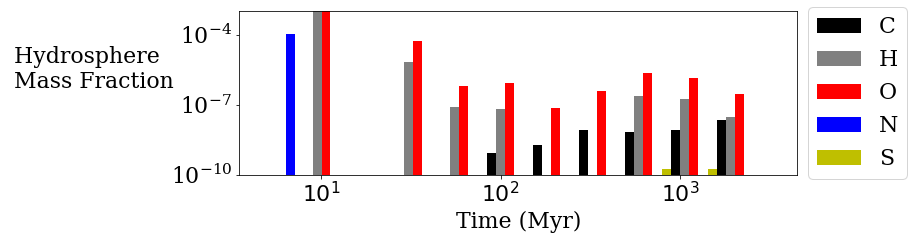

In [12]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

def plot_binned_bar_chart(X, Y, m,lab,col):
    n = len(X)
    # Check if m is valid
    if m >= n:
        raise ValueError("Number of bars (m) must be less than the length of the data (n)")
    # Calculate the bin size
    bin_size = n // m
    # Calculate the bin edges
    bin_edges = np.arange(0, n + bin_size, bin_size)
    # Create an array to store the binned values
    binned_values = np.zeros(m)
    bin_locs = np.zeros(m)
    # Bin the data
    Xlin=np.linspace(X[0],X[-1],len(X))
    for i in range(m):
        start_idx = bin_edges[i]
        end_idx = bin_edges[i + 1] if i < m - 1 else n
        bin_locs[i] = np.mean(Xlin[start_idx:end_idx])
        Xi1=np.argmin(np.abs(X-Xlin[start_idx]))
        Xi2=np.argmin(np.abs(X-Xlin[end_idx-1]))
        binned_values[i] = np.mean(Y[Xi1:Xi2])
    # Plot the binned bar chart
    if lab=="C":
        binned_values[2]=binned_values[4]
        binned_values[4]=0
    plt.bar(bin_locs, binned_values, align='center',width=0.05,label=lab,color=col)
    plt.xlabel('Time (Myr)')
    #plt.ylabel('Wt% relative to hydrosphere')
    #plt.title('Material released into ocean/ice-shell')
    plt.yscale("log")
    #plt.show()
    
Rmass=0
for i in [maxnt-1]:
    for k in range(0,Ceres.nr):
        for j in Ceres.grid[i,k].RockComp:
            Rmass+=Ceres.grid[i,k].RockComp[j]
            
print(Rmass/Ceres.Mass)

mEl=dict()

axes=plt.figure(figsize=(10,3))
for j in ["C","H","O","N","S"]:
    Car=np.zeros(maxnt)
    hydroM=np.zeros(maxnt)
    for i in range(0,maxnt):
        for k in range(0,Ceres.nr):
            if j in Ceres.grid[i,k].AqComp:
                Car[i]+=Ceres.grid[i,k].AqComp[j]
            if j in Ceres.grid[i,k].IceComp:
                Car[i]+=Ceres.grid[i,k].IceComp[j]
            if i>50 and j=="N":
                Car[i]=0
        #for k in range(0,nr):
        #    hydroM[i]+=(Ceres.grid[i,k].AqMass+Ceres.grid[i,k].IceMass)
        #    if j in Ceres.grid[i,k].OrgComp:
        #        Car[i]+=Ceres.grid[i,k].OrgComp[j]
    mEl[j]=Car
    Car=np.diff(Car)
    Car=Car/(Ceres.Mass-Rmass)
    #plt.plot(Ceres.times/3.154e+7/1e6,Car,label=j)
    logTimes = np.log10(Ceres.times/3.154e+7/1e6)
    offset=0
    col='k'
    if j=="H":
        offset=0.05
        col='grey'
    if j=="O":
        offset=0.1
        col='r'
    if j=="S":
        offset=-0.05
        col="y"
    if j=="N":
        offset=-0.1
        col="b"
    logTimes+=offset #/hydroM*100
    #plot_binned_bar_chart(logTimes, Car/Ceres.Mass/ICE_frac*100, 10,j,col)
    plot_binned_bar_chart(logTimes, Car, 12,j,col)
    #plt.plot(logTimes[0:-1],np.cumsum(Car),color=col)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([10**-10,10**-3])
plt.xticks([1, 2, 3], [r'$10^1$', r'$10^2$',r'$10^3$'])
plt.xlim(np.log10([3.5,4.5e3]))
plt.ylabel("Hydrosphere \n Mass Fraction",rotation=0,labelpad=80)
#plt.xscale('log')
#print(Ceres.Mass)

## Figure 2a

/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_21683/4242125046.py:97: RuntimeWarning: invalid value encountered in double_scalars
  pP[i][j] = pP[i][j] / sumM[j]


0.47420536806542624


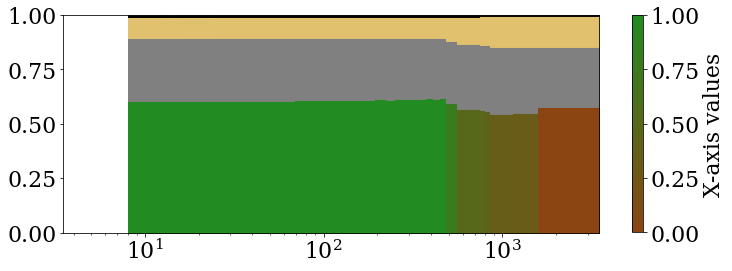

In [14]:
def plotHydration(self,radius):
    pP = dict()
    pP
    Htot=np.zeros(self.nt)
    Htot2=np.zeros(self.nt)
    tt=np.zeros(self.nt)
    
    
    lab_dict = {"IOM": "IOM",
                "IOMp": "IOM pyrolysates",
                "other": "minor phases",
                "gph": "Graphite",
                "q": "Quartz",
                "Opx": "Silicates",
                "Cpx": "Silicates",
                "acm": "Silicates",
                "pyr": "Iron sulfides",
                "Po": "Iron sulfides",
                "tro": "Iron sulfides",
                "lot": "Iron sulfides",
                "trov": "Iron sulfides",
                "Amph": "Silicates",
                "Chl": "Silicates",
                "Tlc": "Silicates",
                "Pu": "Silicates",
                "Do": "Carbonates",
                "Cc": "Carbonates",
                "cc": "Carbonates",
                "dol": "Carbonates",
                "arag": "Carbonates",
                "Pl": "Silicates",
                "ab": "Silicates",
                "hem": "Iron oxides",
                "gth": "Iron oxides",
                "Ol": "Silicates",
                "Sp": "Iron oxides",
                "Atg": "Silicates",
                "glt": "Silicates",
                "cen": "Silicates",
                "ne": "Silicates",
                "pren": "Silicates",
                "en": "Silicates",
                "liz": "Silicates",
                "any": "Sulfates",
                "naph": "Silicates",
                "cor": "Iron oxides", # actually Al oxide
                "Mag": "Carbonates",
                "Gt": "Iron oxides", # actually Al oxide
                "iron": "Iron",
                "mt": "Iron oxides"}

    col_dict = {"IOM": "#964B00",
                "IOM pyrolysates": "#5C4033",
                "minor phases": 'skyblue',
                "Graphite": "#000000",
                "Quartz": "#FFFFFF",
                "Carbonates": "#808080",
                "Anhydrous silicates": "#9ab973",
                "Iron sulfides": "#E1C16E",
                "Hydrous silicates": "#033220",
                "Iron oxides":"#5C4033",
                "Al oxides": "#9A2A2A",
                "Sulfates": "#b0c4de",
                "Iron": "#A9A9A9"}    
    
    for j in range(self.nt):
        tt[j]=self.grid[j][radius].Temp
        phases = self.grid[j][radius].RockPhases
        for i in range(len(phases)):
            if "_rs" in phases[i]:
                phases[i] = phases[i].replace('_rs', '')
            if "_1" in phases[i]:
                phases[i] = phases[i].replace('_1', '')
            if phases[i]=="Bulk":
                Htot[j]+=self.grid[j][radius].RockPhaseDat[i]['H']/100*self.grid[j][radius].RockPhaseDat[i]["wt%"]/100
            else:
                Htot2[j]+=self.grid[j][radius].RockPhaseDat[i]['H']/100*self.grid[j][radius].RockPhaseDat[i]["wt%"]/100
        for i in range(0, len(phases)):
                if not phases[i] == "Bulk":
                    labT = "other"
                    if phases[i] not in lab_dict:
                        print(phases[i])
                    if phases[i] in lab_dict:
                        labT = lab_dict[phases[i]]
                    if labT in pP:
                        pP[labT][j] += self.grid[j][radius].RockPhaseDat[i]["wt%"]
                    else:
                        pP[labT] = np.zeros(self.nt)
                        pP[labT][j] = self.grid[j][radius].RockPhaseDat[i]["wt%"]
                        
    sumM = np.zeros(self.nt)
    for j in range(self.nt):
        for i in pP:
            sumM[j] += pP[i][j]
    for j in range(self.nt):
        for i in pP:
            pP[i][j] = pP[i][j] / sumM[j]
            
            
    YR=3.1536E7
    time=self.times / YR / 10 ** 6
    
    #plt.figure()
    #plt.plot(time,Htot2)
    #plt.plot(time,Htot)
    #plt.xscale("log")
            
    print(Htot2[-1]/np.max(Htot2))
    Htot2[0:1000]=np.max(Htot2)
    Htot2=((Htot2-np.min(Htot2))/(np.max(Htot2)-np.min(Htot2)))
                
    # Generate colors based on the x values using a colormap
    norm = plt.Normalize(Htot2.min(), Htot2.max())
    colors = ['saddlebrown','forestgreen']
    custom_cmap = LinearSegmentedColormap.from_list('forest_brown', colors)
    cmap = plt.cm.gist_earth  # You can choose any colormap here
    colors = custom_cmap(Htot2/np.max(Htot2))
    

    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 4))

    # Stackplot allows for static colors, but to make the colors change over x, we need to plot manually
    for i in range(len(Htot2) - 1):
        ax.fill_between(time[i:i+2], pP["Silicates"][i:i+1], color=colors[i])  # Dynamic color for y2
        # Stack the remaining layers with fixed colors
        bottom = pP["Silicates"][i:i+1]
        for j in pP.keys():
            if not j=="Silicates":
                ax.fill_between(time[i:i+2], bottom + pP[j][i:i+1], bottom, color=col_dict[j])
                bottom += pP[j][i:i+1]
    plt.ylim([0, 1])
    plt.xlim([stime,etime])
    plt.xscale("log")
    
    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])  # Needed for colorbar to work
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('X-axis values')  # Label for colorbar
    #plt.savefig('Fig2a_.pdf')
    
    
    
    
    
plotHydration(Ceres,0)

## Figure 2b

Optimized parameters: L = 3679341754505389568.00, x0 = 911.71, k = 0.01


/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_21683/1708235700.py:23: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))


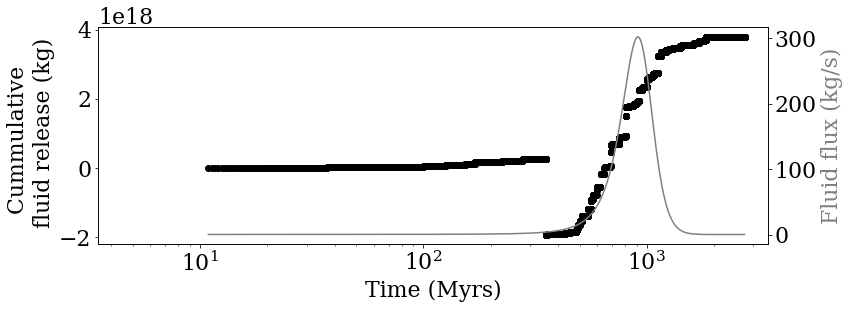

In [15]:
s_index=1683
e_index=11000

si2=25
si3=51
ei2=50
ei3=1682

totM_vol=0

for i in mEl:
    totM_vol+=mEl[i]
    
totM_vol_diff=totM_vol

x_data_2 = Ceres.times[si2:ei2]/3.154e+7/1e6
x_data_3 = Ceres.times[si3:ei3]/3.154e+7/1e6
y_data_2 = totM_vol_diff[si2:ei2]-totM_vol_diff[si2]
y_data_3 = totM_vol_diff[si3:ei3]-totM_vol_diff[si3]

# Define the sigmoid function
def sigmoid(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

# Generate some example data (or replace this with your data)
# For example, let's create some noisy sigmoid data
x_data = Ceres.times[si2:e_index-2]/3.154e+7/1e6
y_data_1 = totM_vol_diff[s_index:e_index]-totM_vol_diff[s_index]+y_data_3[-1]
y_data=np.append(y_data_2,np.append(y_data_3,y_data_1))




# Use curve_fit to fit the sigmoid function to the data
popt, pcov = curve_fit(sigmoid, x_data, y_data, p0=[max(y_data), np.median(x_data), 1])

# popt contains the optimized parameters L, x0, k
L, x0, k = popt

# Print the optimized parameters
print(f"Optimized parameters: L = {L:.2f}, x0 = {x0:.2f}, k = {k:.2f}")


fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()

ax1.set_xlabel('Time (Myrs)')
ax1.set_xscale('log')
ax1.set_xlim([stime,etime])
ax1.set_ylabel('Cummulative \n fluid release (kg)', color='k')
ax2.set_ylabel('Fluid flux (kg/s)', color='grey')
#ax2.set_ylim([10,1e7])


# Plot the data and the fitted curve
ax1.scatter(x_data, y_data, label='Data', color='k')
#ax1.plot(x_data, sigmoid(x_data, *popt), label='Fitted curve', color='blue')
#plt.ylim([0, 1])

kg_per_myr=np.diff(sigmoid(x_data, *popt))/np.diff(x_data)
kg_per_s=kg_per_myr/1e6/3.154e+7
ax2.plot(x_data[0:-1],kg_per_s,color='grey')

#plt.savefig('Fig2b_.pdf')


## Figure 1

(3.4995561192136972, 4110.989195370529)

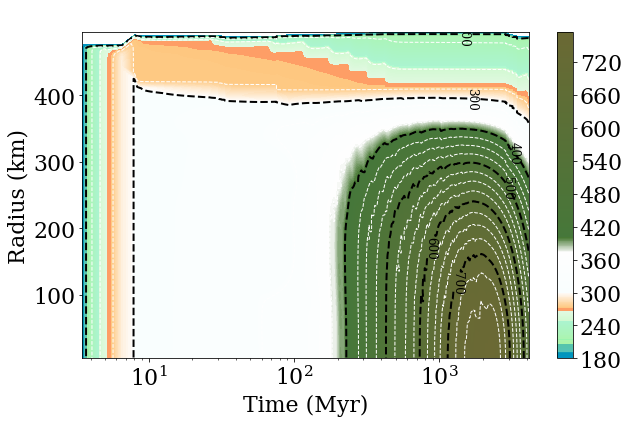

In [13]:
ax = Ceres.plotTemp("Temp"," ")
plt.xscale("log")
plt.xlim([stime,etime])
#plt.ylim([0,476])
#plt.set_cmap('jet')
#plt.savefig('Fig1_temperature.pdf')  

## Figure S3

(3.4995561192136972, 3000.0)

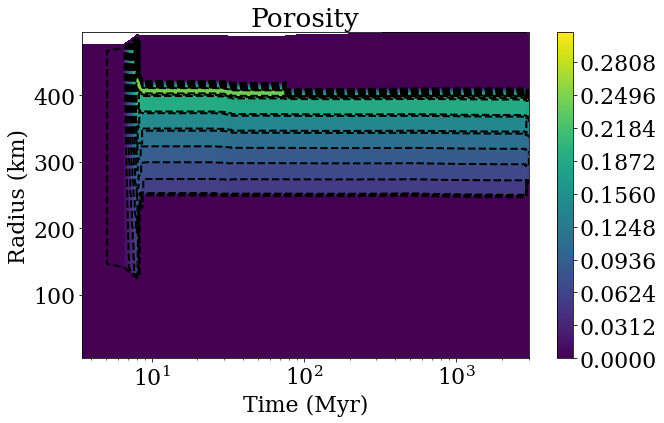

In [14]:
Ceres.plotAttribute("Porosity","Porosity")
plt.xscale("log")
plt.xlim([stime,3e3])
#plt.savefig('FigS3a.pdf') 

(3.4995561192136972, 3000.0)

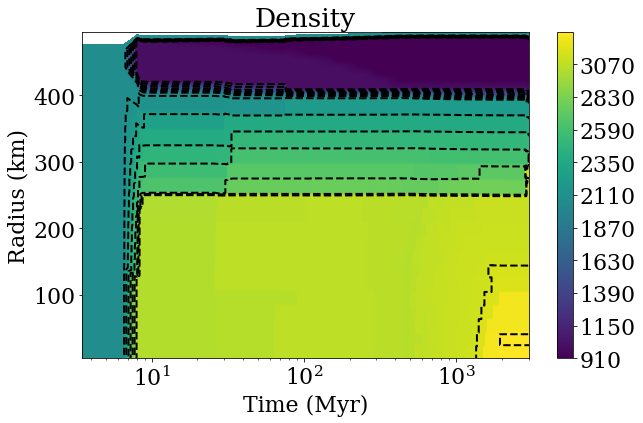

In [15]:
Ceres.plotAttribute("Dens","Density")
plt.xscale("log")
plt.xlim([stime,3e3])
#plt.savefig('FigS3b.pdf') 

(3.4995561192136972, 3000.0)

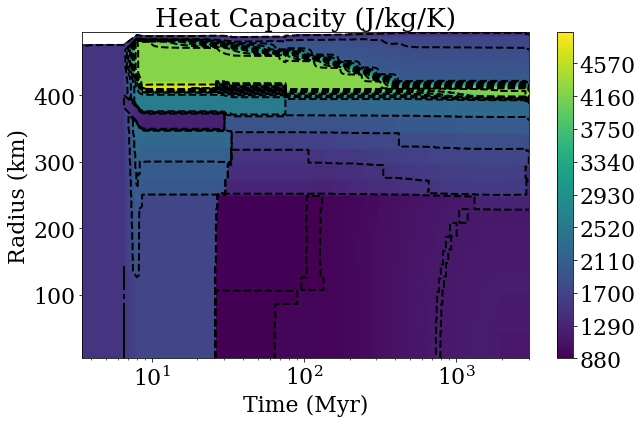

In [16]:
Ceres.plotAttribute("Cp","Heat Capacity (J/kg/K)")
plt.xscale("log")
plt.xlim([stime,3e3])
#plt.savefig('FigS3c.pdf') 

(3.4995561192136972, 3000.0)

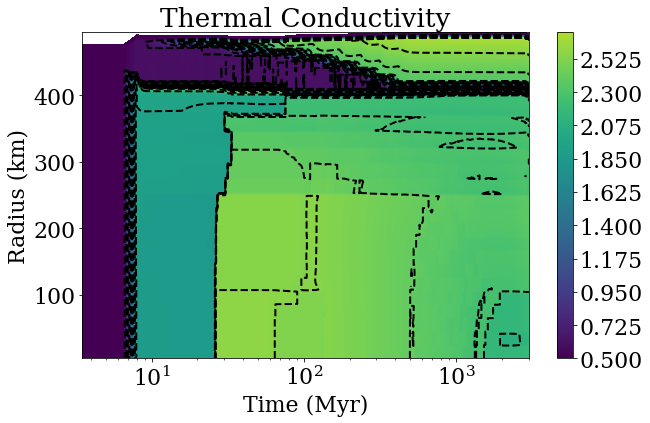

In [17]:
Ceres.plotAttribute("TCond","Thermal Conductivity")
plt.xscale("log")
plt.clim([0.5,3.0])
plt.xlim([stime,3e3])
#plt.savefig('FigS3d.pdf') 

## Figure S6

(3.4995561192136972, 3000.0)

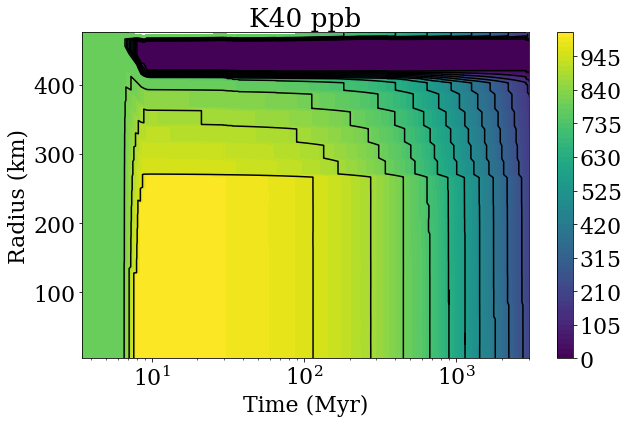

In [21]:
plt.rc('image', cmap="viridis")
Ceres.plotDictAttribute("RIComp","K40","K40 ppb",10**9)
plt.xscale("log")
plt.xlim([stime,3e3])

#plt.savefig('FigS6a.pdf')

(3.4995561192136972, 3000.0)

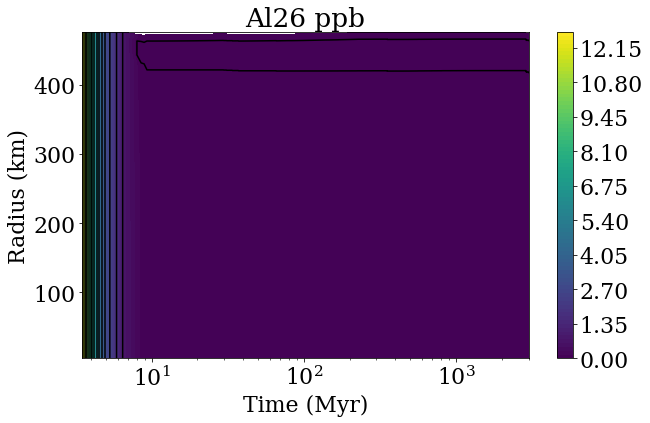

In [22]:
plt.rc('image', cmap="viridis")
Ceres.plotDictAttribute("RIComp","Al26","Al26 ppb",10**9)
plt.xscale("log")
plt.xlim([stime,3e3])

#plt.savefig('FigS6b.pdf')

## Figure S4

In [18]:
def TestMultiplotDictAttributeLine(model,att,keys,tit,radius,unit=1):
    plt.figure(figsize=(10, 6))
    for key in keys:
        data = np.zeros(model.nt)
        for j in range(model.nt):
            tempItem=getattr(model.grid[j][radius], att)
            if key in tempItem:
                data[j]=tempItem[key]
                
        x=model.times[data>1e-9]
        y=data[data>1e-9]
                
        plt.plot(x/3.154e+7/10**6,y,label=key)
    plt.xlabel('Time (Myr)')
    plt.ylabel(tit)
    plt.legend()
    #print(data)

['Cl-' 'OH-' 'H2(aq)' 'NH4+' 'CO2(aq)' 'SO4--' 'N2(aq)' 'HCO3-' 'NH3(aq)'
 'H2S(aq)' 'CO3--' 'HS-' 'Formate' 'Methane(aq)' 'Urea(aq)' 'Acetate'
 'NH4CH3COO(aq)' 'Acetamide(aq)' 'Ethane(aq)' 'Methionine(aq)']


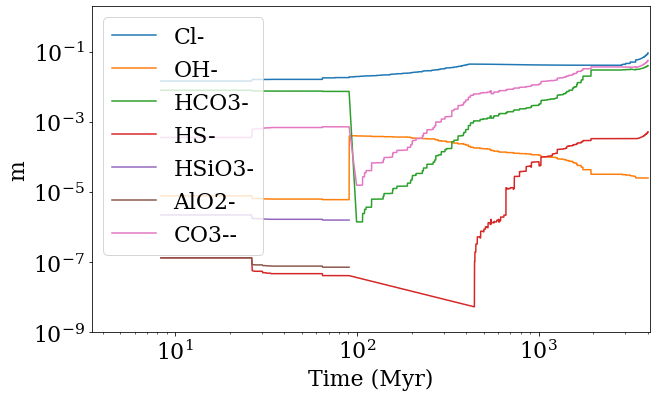

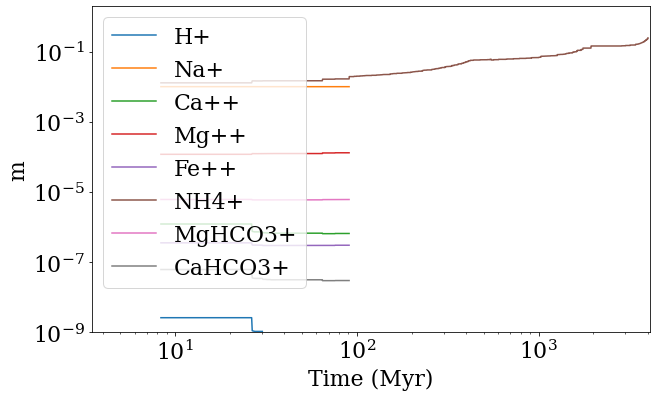

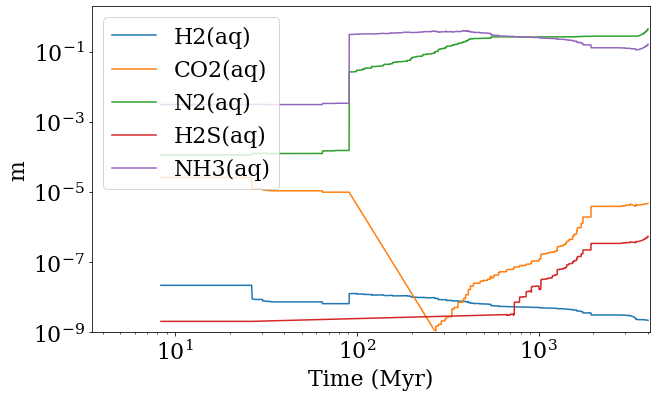

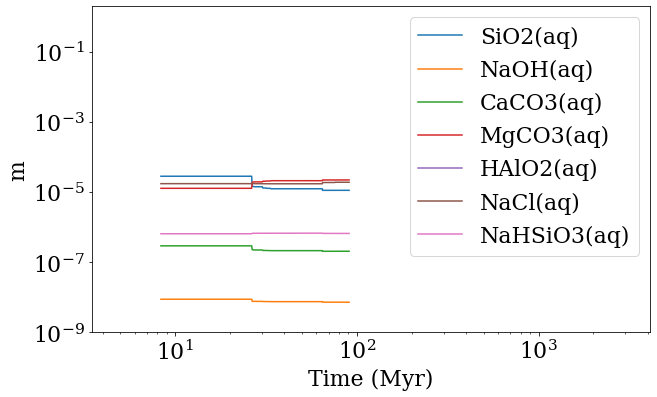

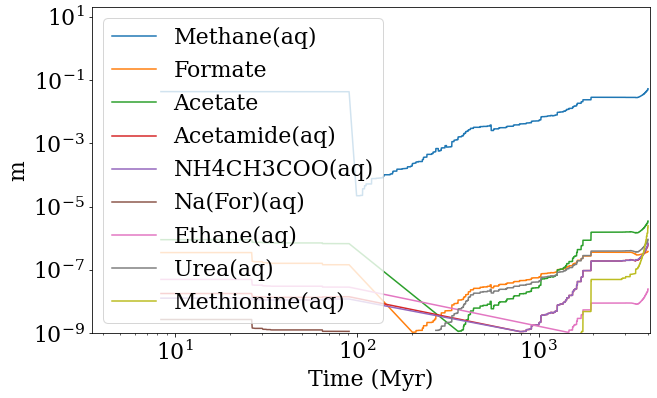

In [25]:
ind=91

names=np.array([])
for i in Ceres.grid[10000,ind].AqSpec:
    if Ceres.grid[10000,ind].AqSpec[i]>1e-9:
        names=np.append(names,[i])
        
print(names)
        
TestMultiplotDictAttributeLine(Ceres,"AqSpec",["Cl-","OH-","HCO3-","HS-","HSiO3-","AlO2-","CO3--"],"m",ind,1)
plt.ylim([10**-9,2])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
#plt.savefig('FigS4a.pdf')

TestMultiplotDictAttributeLine(Ceres,"AqSpec",["H+","Na+","Ca++","Mg++","Fe++","NH4+","MgHCO3+","CaHCO3+"],"m",ind,1)
plt.ylim([10**-9,2])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
#plt.savefig('FigS4b.pdf')

TestMultiplotDictAttributeLine(Ceres,"AqSpec",["H2(aq)","CO2(aq)","N2(aq)","H2S(aq)","NH3(aq)"],"m",ind,1)
plt.ylim([10**-9,2])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
#plt.savefig('FigS4c.pdf')

TestMultiplotDictAttributeLine(Ceres,"AqSpec",["SiO2(aq)","NaOH(aq)","CaCO3(aq)","MgCO3(aq)","HAlO2(aq)","NaCl(aq)","NaHSiO3(aq)"],"m",ind,1)
plt.ylim([10**-9,2])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
#plt.savefig('FigS4d.pdf')

TestMultiplotDictAttributeLine(Ceres,"AqSpec",["Methane(aq)","Formate","Acetate","Acetamide(aq)","NH4CH3COO(aq)","Na(For)(aq)","Ethane(aq)","Urea(aq)","Methionine(aq)"],"m",ind,1)
plt.ylim([10**-9,20])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
#plt.savefig('FigS4e.pdf')

#["Cl-","OH-","HCO3-","HS-","HSiO3-","AlO2-","CO3--"]
#["H2(aq)","CO2(aq)","N2(aq)","H2S(aq)","NH3(aq)"],
#["SiO2(aq)","NaOH(aq)","CaCO3(aq)","MgCO3(aq)","HAlO2(aq)","NaCl(aq)","NaHSiO3(aq)"]
#["H+","Na+","Ca++","Mg++","Fe++","NH4+","MgHCO3+","CaHCO3+"]
#["Methane(aq)","Formate","Acetate","Acetamide(aq)","NH4CH3COO(aq)","Na(For)(aq)","Ethane(aq)","Urea(aq)"]

## Figure S5

['Antigorite' 'Magnetite' 'Pyrite' 'Diaspore' 'Talc' 'Dolomite-ord'
 'Magnesite']


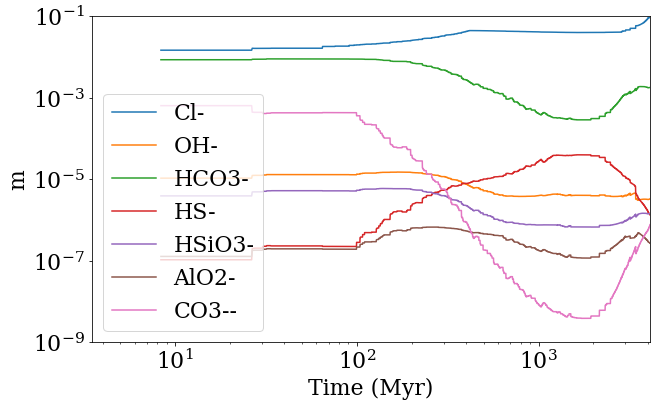

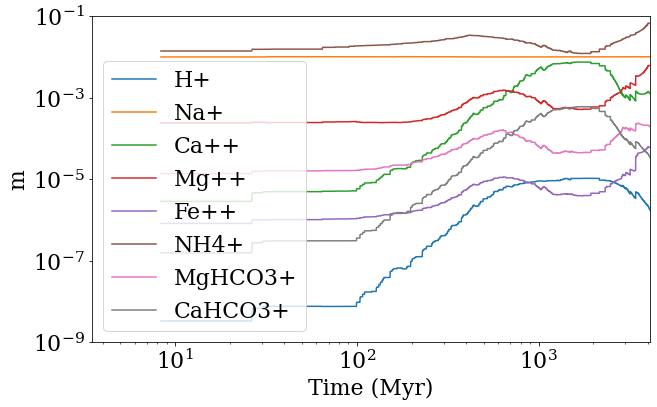

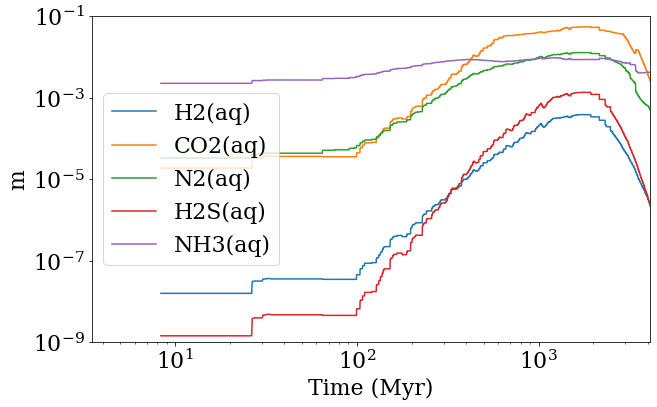

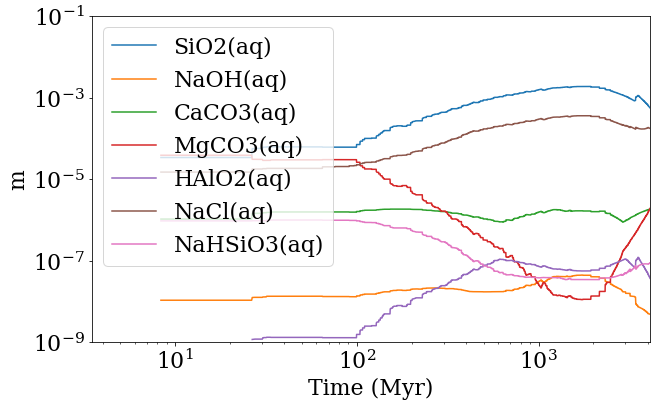

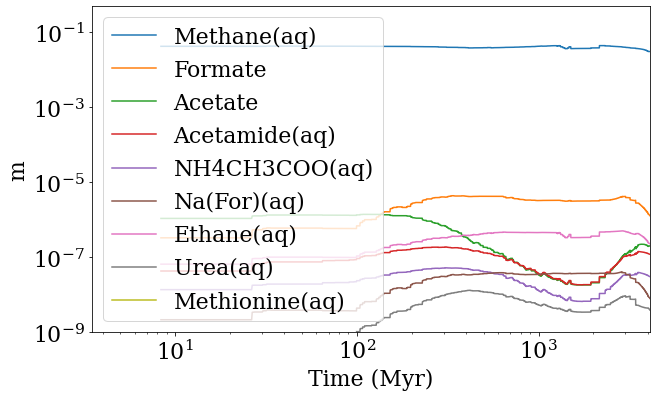

In [26]:
ind=65

names=np.array([])
for i in Ceres.grid[500,ind].AqMin:
    if Ceres.grid[500,ind].AqMin[i]>1e-9:
        names=np.append(names,[i])
        
print(names)
        
TestMultiplotDictAttributeLine(Ceres,"AqSpec",["Cl-","OH-","HCO3-","HS-","HSiO3-","AlO2-","CO3--"],"m",ind,1)
plt.ylim([10**-9,0.1])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
#plt.savefig('FigS5a.pdf')

TestMultiplotDictAttributeLine(Ceres,"AqSpec",["H+","Na+","Ca++","Mg++","Fe++","NH4+","MgHCO3+","CaHCO3+"],"m",ind,1)
plt.ylim([10**-9,0.1])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
#plt.savefig('FigS5b.pdf')

TestMultiplotDictAttributeLine(Ceres,"AqSpec",["H2(aq)","CO2(aq)","N2(aq)","H2S(aq)","NH3(aq)"],"m",ind,1)
plt.ylim([10**-9,0.1])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
#plt.savefig('FigS5c.pdf')

TestMultiplotDictAttributeLine(Ceres,"AqSpec",["SiO2(aq)","NaOH(aq)","CaCO3(aq)","MgCO3(aq)","HAlO2(aq)","NaCl(aq)","NaHSiO3(aq)"],"m",ind,1)
plt.ylim([10**-9,0.1])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
#plt.savefig('FigS5d.pdf')

TestMultiplotDictAttributeLine(Ceres,"AqSpec",["Methane(aq)","Formate","Acetate","Acetamide(aq)","NH4CH3COO(aq)","Na(For)(aq)","Ethane(aq)","Urea(aq)","Methionine(aq)"],"m",ind,1)
plt.ylim([10**-9,0.5])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
#plt.savefig('FigS5e.pdf')

#["Cl-","OH-","HCO3-","HS-","HSiO3-","AlO2-","CO3--"]
#["H2(aq)","CO2(aq)","N2(aq)","H2S(aq)","NH3(aq)"],
#["SiO2(aq)","NaOH(aq)","CaCO3(aq)","MgCO3(aq)","HAlO2(aq)","NaCl(aq)","NaHSiO3(aq)"]
#["H+","Na+","Ca++","Mg++","Fe++","NH4+","MgHCO3+","CaHCO3+"]
#["Methane(aq)","Formate","Acetate","Acetamide(aq)","NH4CH3COO(aq)","Na(For)(aq)","Ethane(aq)","Urea(aq)"]

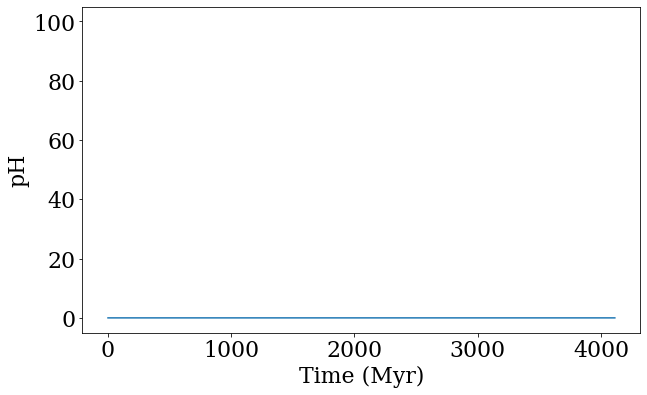

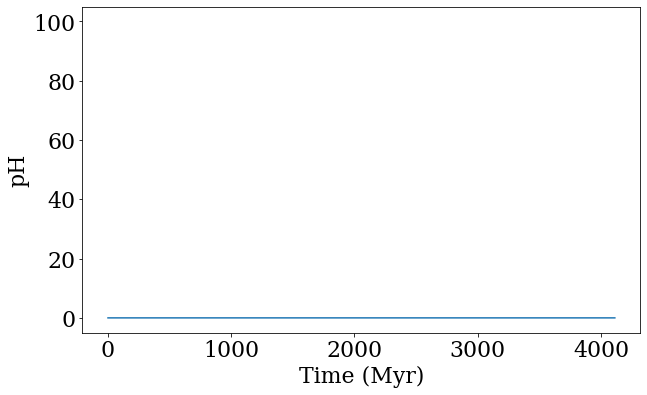

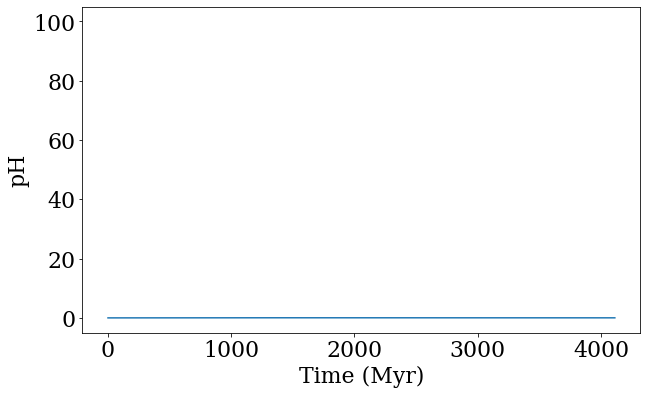

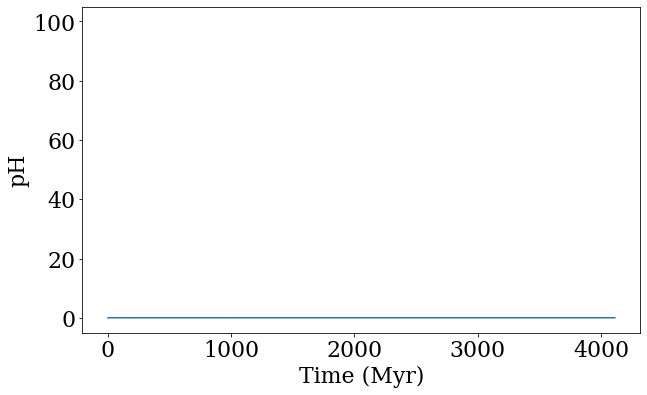

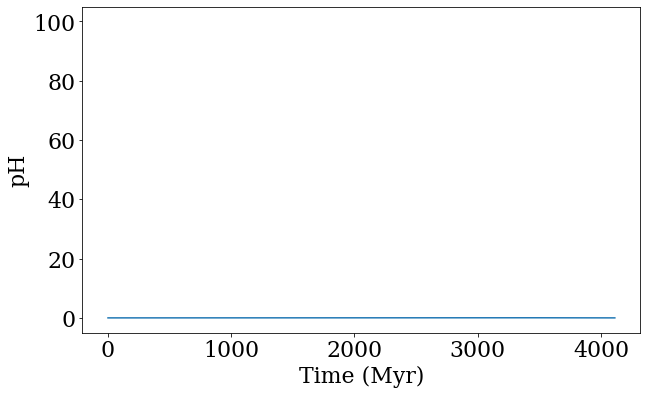

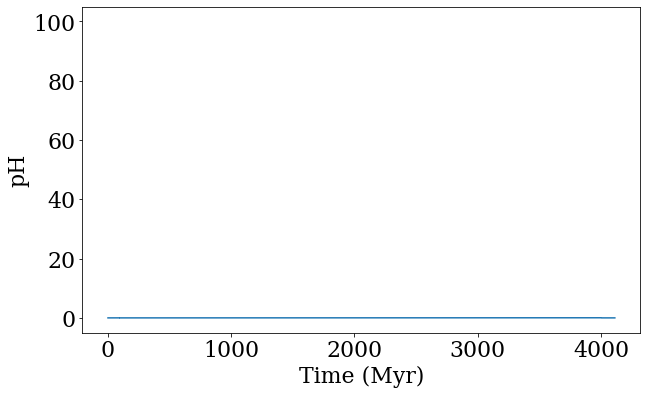

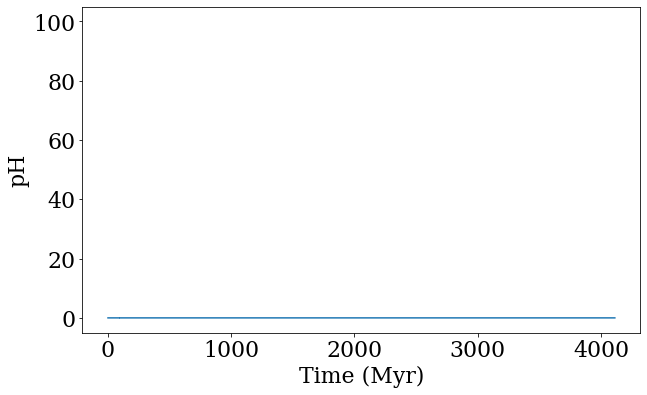

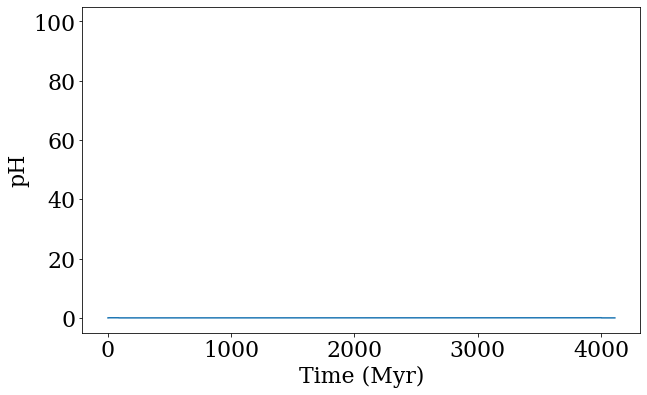

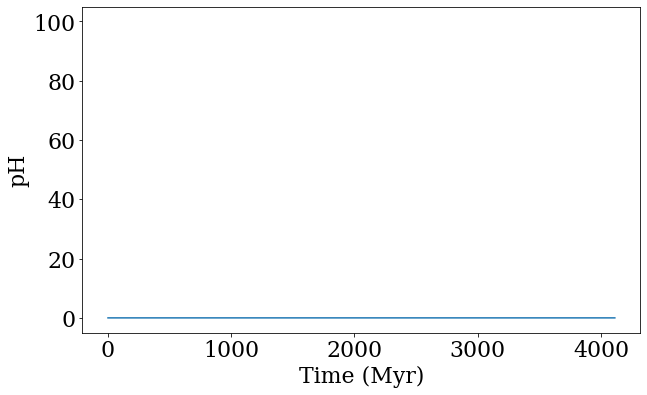

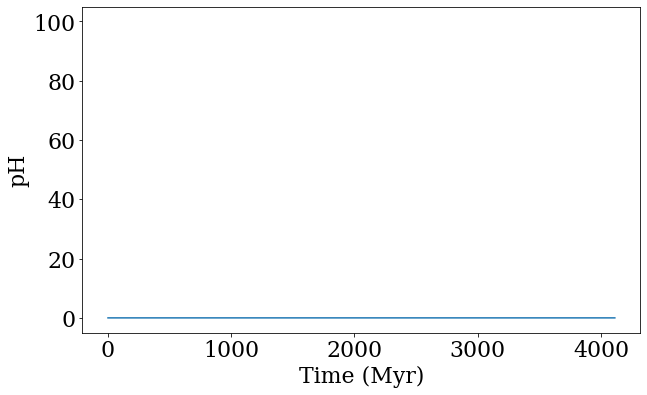

In [27]:
indD=69
indS=91

f,CO3_d=Ceres.plotDictAttributeLine("AqSpec","CO3--","pH",indD,1)
f,HCO3_d=Ceres.plotDictAttributeLine("AqSpec","HCO3-","pH",indD,1)
f,CO2_d=Ceres.plotDictAttributeLine("AqSpec","CO2(aq)","pH",indD,1)
f,CH4_d=Ceres.plotDictAttributeLine("AqSpec","Methane(aq)","pH",indD,1)
f,CO3=Ceres.plotDictAttributeLine("AqSpec","CO3--","pH",indS,1)
f,HCO3=Ceres.plotDictAttributeLine("AqSpec","HCO3-","pH",indS,1)
f,CO2=Ceres.plotDictAttributeLine("AqSpec","CO2(aq)","pH",indS,1)
f,CH4=Ceres.plotDictAttributeLine("AqSpec","Methane(aq)","pH",indS,1)

f,H2_d=Ceres.plotDictAttributeLine("AqSpec","H2(aq)","pH",indD,1)
f,H2=Ceres.plotDictAttributeLine("AqSpec","H2(aq)","pH",indS,1)

## Figure 3c

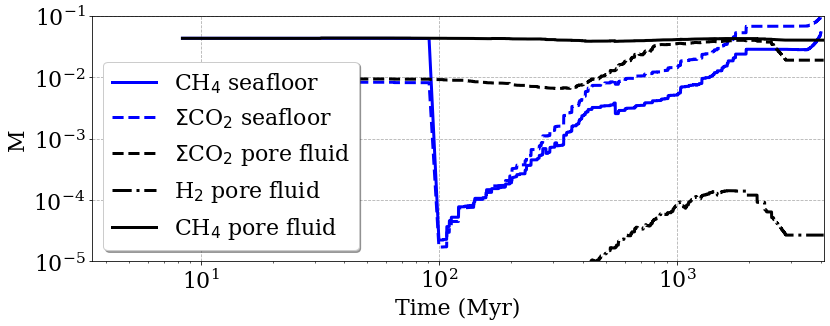

In [28]:
plt.figure(figsize=(12, 5))

ind_good=CH4>1e-9
ind_good_d=CH4_d>1e-9

CO_d=CO3_d+HCO3_d+CO2_d
CO=CO3+HCO3+CO2

#plt.plot(Ceres.times/3.154e+7/1e6,HCO3+CO2,'k-',label=r"HCO$_3^-$")
plt.plot(Ceres.times[ind_good]/3.154e+7/1e6,CH4[ind_good],'b',label=r"CH$_4$ seafloor",linewidth=3)
plt.plot(Ceres.times[ind_good]/3.154e+7/1e6,CO[ind_good],'b',label=r"$\Sigma$CO$_2$ seafloor",linewidth=3,linestyle='--')
#plt.plot(Ceres.times/3.154e+7/1e6,HCO3_d+CO2_d,'b',label=r"HCO$_3^-$")
plt.plot(Ceres.times[ind_good_d]/3.154e+7/1e6,CO_d[ind_good_d],'k',label=r"$\Sigma$CO$_2$ pore fluid",linewidth=3,linestyle='--')


plt.plot(Ceres.times[ind_good_d]/3.154e+7/1e6,H2_d[ind_good_d],'k',label=r"H$_2$ pore fluid",linewidth=3,linestyle='-.')
plt.plot(Ceres.times[ind_good_d]/3.154e+7/1e6,CH4_d[ind_good_d],'k',label=r"CH$_4$ pore fluid",linewidth=3)
#plt.plot(Ceres.times/3.154e+7/1e6,H2,'k-',label=r"H$_2$(aq)",linewidth=3)
plt.ylim([1e-5,0.1])
plt.xlim([stime,etime])
plt.xlabel("Time (Myr)")
plt.ylabel("M")
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='lower left',
               ncol=1, fancybox=True, shadow=True) #bbox_to_anchor=(1.00, 1.0), 
plt.grid(True, linestyle='--')
plt.yticks([0.1, 0.01, 0.001,0.0001,0.00001])
#plt.set_yticks([0.3, 0.55, 0.7], minor=True)
plt.tight_layout()
#plt.savefig('Fig4b.pdf')

## Figure 3d

/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_42710/4292846416.py:30: RuntimeWarning: invalid value encountered in true_divide
  logK_e = np.log10(CH4_s_e/(H2_s_e**4*CO2E_s_e))
/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_42710/4292846416.py:34: RuntimeWarning: invalid value encountered in true_divide
  logK_e_d = np.log10(CH4_d_e/(H2_d_e**4*CO2E_d_e))


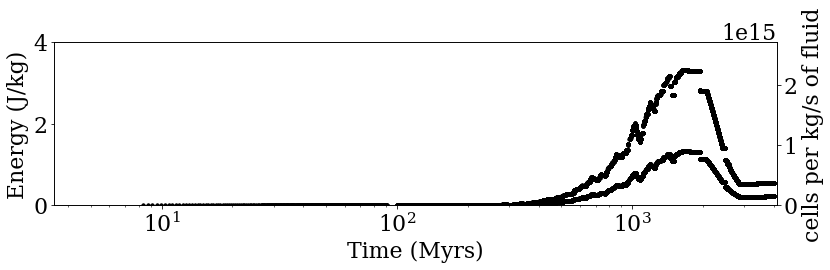

In [40]:
#indE = 50
#indL = 5000

ind_good=np.logical_and(CH4>1e-9, CH4_d>1e-9)


#ind_good=list(set(ind_good) & set(ind_good_2))

CO2E_s_e = HCO3 + CO2 + CO3
CH4_s_e = CH4
H2_s_e = H2


CO2E_d_e = HCO3_d + CO2_d + CO3_d
CH4_d_e = CH4_d
H2_d_e = H2_d


CO2E_s_l = HCO3 + CO2 + CO3
CH4_s_l = CH4
H2_s_l = H2


CO2E_d_l = HCO3_d + CO2_d + CO3_d
CH4_d_l = CH4_d
H2_d_l = H2_d



logK_e = np.log10(CH4_s_e/(H2_s_e**4*CO2E_s_e))
#logK_l = np.log10(CH4_s_l/(H2_s_l**4*CO2E_s_l))


logK_e_d = np.log10(CH4_d_e/(H2_d_e**4*CO2E_d_e))
#logK_l_d = np.log10(CH4_d_l/(H2_d_l**4*CO2E_d_l))


R = 8.314 # J/(K mol)
T = 273  # K


AE = np.log(10)*R*T*(logK_e-logK_e_d)



EE = AE*H2_d_e/4 #np.min([H2_d_e/4,CO2E_d_e])



EE[8100:9390]=np.linspace(EE[8100],EE[9390],9390-8100)


#[ind_good_d]
#plt.figure(figsize=(12, 4))
#plt.plot(Ceres.times[ind_good]/3.154e+7/1e6,EE[ind_good],'k',linewidth=2)
#plt.axhline(y=20, color='k', linestyle='--')
#plt.xscale('log')
#plt.ylim([0,65])
#plt.xlim([2.5,4.5e3])
#plt.xlabel('Time (Myrs)')
#plt.ylabel('Energy (J/kg)')

ME = 3.7e-15
Cells=EE/ME
#plt.figure(figsize=(12, 4))
#plt.plot(Ceres.times[ind_good]/3.154e+7/1e6,Cells[ind_good],'k',linewidth=2)
#plt.axhline(y=20, color='k', linestyle='--')
#plt.xscale('log')
#plt.yscale('log')
#plt.ylim([10,1e7])
#plt.xlim([2.5,4.5e3])
#plt.xlabel('Time (Myrs)')
#plt.ylabel('cells per kg/s of fluid')


fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()
ax1.plot(Ceres.times[ind_good]/3.154e+7/1e6,EE[ind_good],'k.',linewidth=2)
ax2.plot(Ceres.times[ind_good]/3.154e+7/1e6,Cells[ind_good],'k.',linewidth=2)

ax1.set_xlabel('Time (Myrs)')
ax1.set_xscale('log')
plt.xlim([stime,etime])
ax1.set_ylabel('Energy (J/kg)', color='k')
ax2.set_ylabel('cells per kg/s of fluid', color='k')
#ax2.set_yscale('log')
#ax2.set_ylim([1e9,1e14])
ax2.set_ylim([0,(10/3.7)*1e15])
ax1.set_ylim([0,4])
plt.tight_layout()
#plt.savefig('Fig4c.pdf')



## Figure 2d

In [ ]:
f,H=Ceres.plotDictAttributeLine("AqSpec","H+","pH",93,1)
f,NH4=Ceres.plotDictAttributeLine("AqSpec","NH4+","NH4",87,1)
f,NH3=Ceres.plotDictAttributeLine("AqSpec","NH3(aq)","NH3",87,1)
f,N2=Ceres.plotDictAttributeLine("AqSpec","N2(aq)","N2",87,1)

H[22:55]=H[55]

ind_good=-np.log10(H)>8

plt.figure(figsize=(12, 4))
plt.plot(Ceres.times[ind_good]/3.154e+7/1e6,-np.log10(H[ind_good]),'k')
plt.ylim([8,11])
plt.xlim([2.5,4e3])
plt.xlabel("Time (Myr)")
plt.ylabel(r"pH")
plt.xscale('log')

In [ ]:
#plt.scatter(Ceres.times/3.154e+7/1e6,HCO3,label="HCO3-")
#plt.scatter(Ceres.times/3.154e+7/1e6,CO2,label="CO2(aq)")
#plt.scatter(Ceres.times/3.154e+7/1e6,CH4,label="CH4(aq)")
#plt.legend()
#plt.ylim([10**-3,1])
#plt.yscale('log')
#plt.xscale('log')


ind_good=CH4>1e-6
ind_good_2=NH4>1e-6

fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()
#plt.plot(Ceres.times[ind_good]/3.154e+7/1e6,HCO3[ind_good],'k-',label=r"HCO$_3^-$")
#plt.plot(Ceres.times[ind_good]/3.154e+7/1e6,CO2[ind_good],'k--',label=r"CO$_2$")
#plt.plot(Ceres.times[ind_good]/3.154e+7/1e6,CH4[ind_good],'k-.',label=r"CH$_4$(aq)")
ax2.plot(Ceres.times[ind_good]/3.154e+7/1e6,CO3[ind_good]+HCO3[ind_good]+CO2[ind_good],'k',label=r"DIC")
ax2.plot(Ceres.times[ind_good_2]/3.154e+7/1e6,NH3[ind_good_2]+NH4[ind_good_2]+N2[ind_good_2],'k--',label=r"TAN")
#plt.plot(Ceres.times[ind_good_2]/3.154e+7/1e6,NH4[ind_good_2],'b',label=r"NH$_4^+$")
#plt.plot(Ceres.times[ind_good]/3.154e+7/1e6,HS[ind_good]*5,'y',label=r"HS$^-$")
ax2.set_ylim([10**-2,10**-0.75])
plt.xlim([stime,etime])
plt.xlabel("Time (Myr)")
ax2.set_ylabel("Molality")
ax2.set_yscale('log')
plt.xscale('log')


ind_good=-np.log10(H)>8

ax1.plot(Ceres.times[ind_good]/3.154e+7/1e6,-np.log10(H[ind_good]),'grey')
ax2.plot(Ceres.times[ind_good]/3.154e+7/1e6,-np.log10(H[ind_good]),'grey',label="pH")
ax1.set_ylim([8,10])
ax1.set_ylabel("pH",color='grey')

ax2.legend(bbox_to_anchor=(0, 1.1), loc='upper left',
               ncol=1, fancybox=True, shadow=True)

plt.savefig('Fig3c.pdf')

## Figure 3b

In [ ]:
T_93 = np.zeros(Ceres.nt)
T_66 = np.zeros(Ceres.nt)

for i in range(0,Ceres.nt):
    T_93[i]=Ceres.grid[i,93].Temp
    T_66[i]=Ceres.grid[i,66].Temp

plt.figure(figsize=(12, 4))
plt.plot(Ceres.times/3.154e+7/1e6,T_93,'k',label="seafloor")
plt.plot(Ceres.times/3.154e+7/1e6,T_66,'k--',label="125 km beneath seafloor")
plt.xscale("log")
plt.ylim([250,550])
plt.xlim([stime,etime])
plt.ylabel("Temperature (K)")
plt.legend()
plt.savefig('Fig3b.pdf')

## Figure 2c

In [ ]:
bottom=np.zeros(Ceres.nt)
top=np.zeros(Ceres.nt)
aQMass=np.zeros(Ceres.nt)
aQMass2=np.zeros(Ceres.nt)
aQMass3=np.zeros(Ceres.nt)
toptop=np.zeros(Ceres.nt)

for i in range(0,Ceres.nt):
    for j in range(0,nr-1):
        aQMass2[i]+=Ceres.grid[i,j].getAqMass()
    for j in range(92,nr-1):
        aQMass3[i]+=Ceres.grid[i,j].getAqMass()
        #if not Ceres.grid[i,j].Celltype==3:
        #    aQMass2[i]+=Ceres.grid[i,j].getAqMass()
        #if Ceres.grid[i,j].Celltype==3 and Ceres.grid[i,j+1].Celltype==2:
        #    aQMass2[i]+=Ceres.grid[i,j].getAqMass()

    
    botInd=nr
    toptop[i]=Ceres.grid[i,-1].Top
    for j in range(0,nr):
        if Ceres.grid[i,j].Celltype==2:
            bottom[i]=Ceres.grid[i,j].Bot
            botInd=j
            break
    for j in range(botInd-1,nr):
            aQMass[i]+=Ceres.grid[i,j].getAqMass()
    for j in range(0,nr):
        if Ceres.grid[i,nr-j-1].Celltype==2:
            top[i]=Ceres.grid[i,nr-j-1].Top
            break

thicknessR=top-bottom

In [ ]:
RRR=4*np.pi*(400*1000)**2
Voc=aQMass3/1000
Doc=Voc/RRR

#Doc[7000:-1]=np.ones(len(Doc)-7001)*np.linspace()
#Doc[-1]=0

plt.figure(figsize=(12, 4))
plt.plot(Ceres.times/3.154e+7/1e6,Doc/1000,'k')
plt.xlim([stime,etime])
plt.ylim([0,100])
plt.xlabel("Time (Myr)")
plt.ylabel("Ocean \n thickness (km)")#, rotation=0, labelpad=80)
plt.xscale('log')
plt.tight_layout()
plt.savefig('Fig3a.pdf')

print(Doc[-1]/1000)

print(aQMass[-1])

## Figure 3a

In [32]:
from plotHelper import *
from decay import *

def plotTempTest(self,att,tit):
    matplotlib.rcParams.update({'font.size': 22})
    data = np.zeros((self.nt,self.nr))
    for i in range(self.nr):
        for j in range(self.nt):
            data[j][i]=getattr(self.grid[j][i], att)
    f=plt.figure(figsize=(10,6))
    #print(np.shape(self.radii[0:-1]))
    #print(np.shape(self.times))
    #print(np.shape(self.grid))
    vmin, vmax, JCmap = gmt_colormap()

    major_levels = [*range(300, 2300, 100)]
    #major_levels = [100,200,273] + major_levels
    major_levels = [100,200] + major_levels
    minor_levels = [ x for x in range(100, 1800, 25) if x not in major_levels ]
    
    xi=np.zeros([self.nt,self.nr])
    yi=np.zeros([self.nt,self.nr])
    
    for i in range(0,self.nt):
        for j in range(0,self.nr):
            xi[i,j]=self.times[i]/Decay.YR/10**6
            yi[i,j]=self.grid[i,j].Top
            
    #xi=self.times/Decay.YR/10**6
    #yi=self.radii[0:-1]/1000
    zi=np.transpose(data)
    xi=np.transpose(xi)
    yi=np.transpose(yi)

    CS1 = plt.contour( xi,yi/1000,zi, levels=major_levels, linewidths=2.0, colors='black', linestyles='dashed' )

    # labels on a subset of the major contour lines
    labeled_levels = [ x for x in major_levels ]
    clabels = plt.clabel( CS1, labeled_levels, fmt='%.0f', fontsize=12 )
    for label in clabels:
        label.set_rotation(-90)

    CS2 = plt.contour( xi,yi/1000,zi, levels=minor_levels, linewidths=1.0, colors='white', linestyles='dashed' )
    CS3 = plt.contourf(xi,yi/1000,zi, 500,vmin=vmin,vmax=vmax,cmap=JCmap) # Fix to use correct radii
    cbar=plt.colorbar()
    cbar.set_ticks(np.linspace(180,900,10))
    #plt.contour(self.times/Decay.YR/10**6,self.radii[0:-1]/1000,np.transpose(data),15, colors='k')
    plt.xlabel('Time (Myr)')
    plt.ylabel('Radius (km)')
    plt.title(tit)
    return f

In [33]:
def plotAttributeTest(self,att,tit):
    matplotlib.rcParams.update({'font.size': 22})
    data = np.zeros((self.nt,self.nr))
    for i in range(self.nr):
        for j in range(self.nt):
            data[j][i]=getattr(self.grid[j][i], att)
    f=plt.figure(figsize=(10,6))

    xi = np.zeros([self.nt, self.nr])
    yi = np.zeros([self.nt, self.nr])

    for i in range(0, self.nt):
        for j in range(0, self.nr):
            xi[i, j] = self.times[i] / Decay.YR / 10 ** 6
            yi[i, j] = self.grid[i, j].Top/1000
            
            
    temp = np.zeros((self.nt,self.nr))
    for i in range(self.nr):
        for j in range(self.nt):
            temp[j][i]=getattr(self.grid[j][i], "Temp")

    # xi=self.times/Decay.YR/10**6
    # yi=self.radii[0:-1]/1000
    zi = np.transpose(data)
    zi2 = np.transpose(temp)
    xi = np.transpose(xi)
    yi = np.transpose(yi)

    #CS1 = plt.contour( xi,yi,zi, 15, linewidths=2.0, colors='black', linestyles='dashed' )

    # labels on a subset of the major contour lines
    #labeled_levels = [ x for x in major_levels ]
    #clabels = plt.clabel( CS1, labeled_levels, fmt='%.0f', fontsize=12 )
    #for label in clabels:
    #    label.set_rotation(-90)

    CS3 = plt.contourf(xi,yi,zi, 500) #,vmin=vmin,vmax=vmax,cmap=JCmap) # Fix to use correct radii
    plt.contour( xi,yi,zi2, levels=[400,600,800], linewidths=1.0, colors='k', linestyles='dashed' )
    plt.colorbar()
    plt.xlabel('Time (Myr)')
    plt.ylabel('Radius (km)')
    plt.title(tit)
    return f

Text(0.5, 1.0, '')

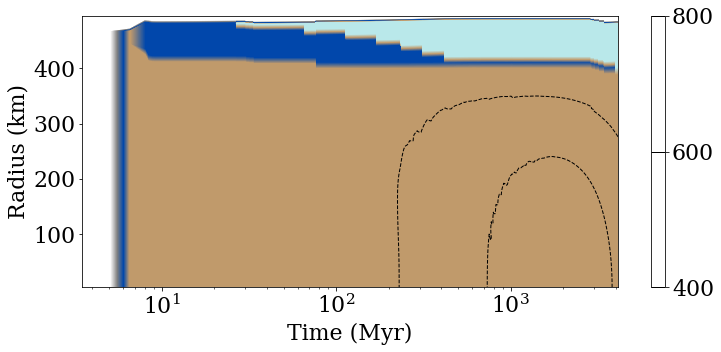

In [34]:
# Define the colors and ranges
colors = ['white', 'grey', '#0047AB', '#C19A6B', '#b9e8ea']
# Create a colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)
plt.rc('image', cmap=custom_cmap)
ax=plotAttributeTest(Ceres,"Celltype","")
plt.xscale("log")
plt.xlim([stime,etime])
ax.set_size_inches(12, 5, forward=True)
plt.title("")
#plt.savefig('Fig4a.pdf')

## Figure S2

/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_42710/2990384996.py:116: RuntimeWarning: invalid value encountered in double_scalars
  pP[i][j]=pP[i][j]/sumM[j]*(100-IOMp)


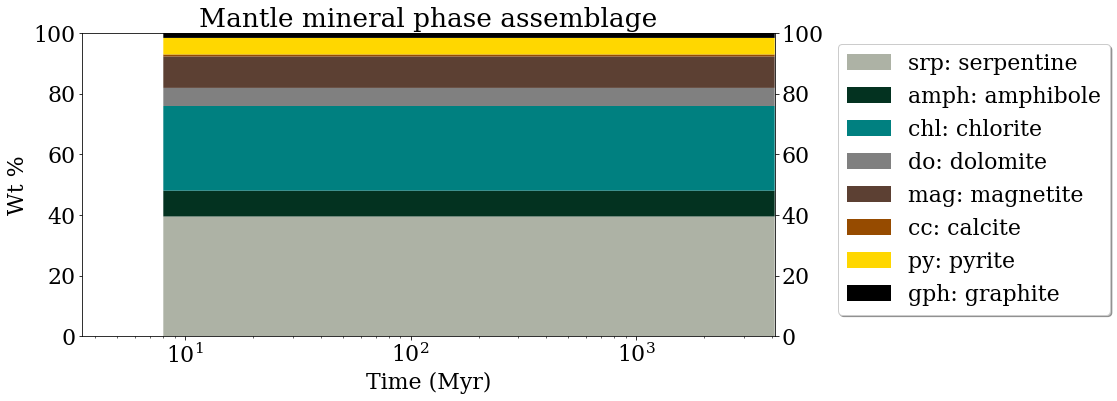

In [37]:
def plotPhaseAssemblageTest(self,radius,title, minorPhases="test"):
    pP=dict()

    if minorPhases=="test":
        minorPhases= ['F','Mica', 'Fsp', 'Sp', 'ky', 'Gt', 'trd', 'crst','Stlp','law','Pu','ank','Mica','Bio','Fsp','Sp']

    col_dict={"IOM":"#964B00",
              "IOM pyrolysates":"#5C4033",
              "minor phases":'skyblue',
              "gph: graphite":"#000000",
              "qtz: quartz":"#FFFFFF",
              "cc: calcite":"#964B00",
              "mg: magnesite":"#d2b48c",
              "do: dolomite":"#808080",
              "px: pyroxene":"#454B1B",
              "py: pyrite":"#FFD700",
              "po: pyrrhotite":"#E1C16E",
              "amph: amphibole":"#033220",
              "chl: chlorite":"#008080",
              "tlc: talc":"#D3D3D3",
              "pl: plagioclase":"#FF0000",
              "hem: hematite":"#b7410e",
              "gth: goethite":"#A9A9A9",
              "mag: magnetite":"#5C4033",
              "sp: spinel":"#E6E6FA",
              "srp: serpentine":"#adb2a5",
              "su: sulfates":"#b0c4de",
              "phl: phlogopite":"#d53600",
              "tro: troilite":"#C0C0C0",
              "ol: olivine":"#9ab973",
              "ens: enstatite":"#CC7722",
              "cor: corundum":"#e0115f",
              "gt: garnet":"#9A2A2A",
              "pu: pu: pumpellyite":"skyblue",
              "Iron":"#A9A9A9"}

    lab_dict={"IOM":"IOM",
              "IOMp":"IOM pyrolysates",
              "other":"minor phases",
              "gph":"gph: graphite",
              "q":"qtz: quartz",
              "Opx":"px: pyroxene",
              "Cpx":"px: pyroxene",
              "acm":"px: pyroxene",
              "pyr":"py: pyrite",
              "Po":"po: pyrrhotite",
              "tro":"tro: troilite",
              "lot":"tro: troilite",
              "trov":"po: pyrrhotite",
              "Amph":"amph: amphibole",
              "Chl":"chl: chlorite",
              "Tlc":"tlc: talc",
              "Do":"do: dolomite",
              "Cc":"cc: calcite",
              "cc": "cc: calcite",
              "dol":"do: dolomite",
              "arag":"cb: carbonates",
              "Pl":"pl: plagioclase",
              "ab":"pl: plagioclase",
              "hem":"hem: hematite",
              "gth": "gth: goethite",
              "Ol":"ol: olivine",
              "Sp":"mag: magnetite",
              "Atg":"srp: serpentine",
              "glt":"srp: serpentine",
              "cen":"ens: enstatite",
              "pren": "ens: enstatite",
              "en": "ens: enstatite",
              "liz": "srp: serpentine",
              "any":"su: sulfates",
              "naph":"phl: phlogopite",
              "cor":"cor: corundum",
              "Mag":"mg: magnesite",#"mag: magnetite",
              "Gt":"gt: garnet",
              "Pu":"pu: pumpellyite",
              "iron":"Iron"}


    for j in range(self.nt):
        phases=self.grid[j][radius].RockPhases
        for i in range(len(phases)):
            if "_rs" in phases[i]:
                phases[i]=phases[i].replace('_rs','')
            if "_1" in phases[i]:
                phases[i]=phases[i].replace('_1','')
        for i in range(0,len(phases)):
            if not phases[i]=="Bulk":
                labT="other"
                if phases[i] not in minorPhases and phases[i] not in lab_dict:
                    print(phases[i])
                if phases[i] in lab_dict:
                    labT=lab_dict[phases[i]]
                if labT in pP:
                    pP[labT][j]+=self.grid[j][radius].RockPhaseDat[i]["wt%"]
                else:
                    pP[labT]=np.zeros(self.nt)
                    pP[labT][j]=self.grid[j][radius].RockPhaseDat[i]["wt%"]
        if "IOM" in self.grid[j][radius].RockComp and self.grid[j][radius].RockComp["IOM"]>0:
            if "IOM" in pP: 
                pP["IOM"][j]+=self.grid[j][radius].RockComp["IOM"]/self.grid[j][radius].Mass*100
            else:
                pP["IOM"]=np.zeros(self.nt)
                pP["IOM"][j]=self.grid[j][radius].RockComp["IOM"]/self.grid[j][radius].Mass*100
    sumM=np.zeros(self.nt)
    for j in range(self.nt):
        for i in pP:
            if not i=="IOM":
                sumM[j]+=pP[i][j]
    for j in range(self.nt):
        if "IOM" in pP:
            IOMp=pP["IOM"][j]
        else:
            IOMp=0
        for i in pP:
            if not i=="IOM":
                pP[i][j]=pP[i][j]/sumM[j]*(100-IOMp)


    #x_values = list(pP.keys())
    #y_values_list = list(pP.values())

    #print(pP.values())
    #print(pP.keys())



    color_map=[]
    for i in pP:
        if i in col_dict:
            color_map.append(col_dict[i])
        else:
            color_map.append(col_dict['minor phases'])


    f=plt.figure(figsize=(12,6))
    plt.stackplot(self.times/Decay.YR/10**6,pP.values(),labels=pP.keys(),colors = color_map) 
    #plt.stackplot(x_values, y_values_list, labels=list(pP.keys()))
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    #if LogScale==1:
    #    plt.xscale("log")
    plt.xlabel('Time (Myr)')
    plt.ylabel('Wt %')
    plt.title(title)
    #plt.title('Phase assemblage at %0.2f kms deep'%(self.radii[-1]-self.radii[radius]))
    plt.tick_params(labelright=True, right=True)
    plt.ylim([0,100])
    plt.xlim([stime,etime])
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.5, 1.0), loc='upper right',
               ncol=1, fancybox=True, shadow=True)
    #plt.show()
    return f

plotPhaseAssemblageTest(Ceres,90, "Mantle mineral phase assemblage",minorPhases="test")
plt.xscale("log")
#plt.savefig('FigS2a.pdf',bbox_inches='tight')

/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_42710/2990384996.py:116: RuntimeWarning: invalid value encountered in double_scalars
  pP[i][j]=pP[i][j]/sumM[j]*(100-IOMp)


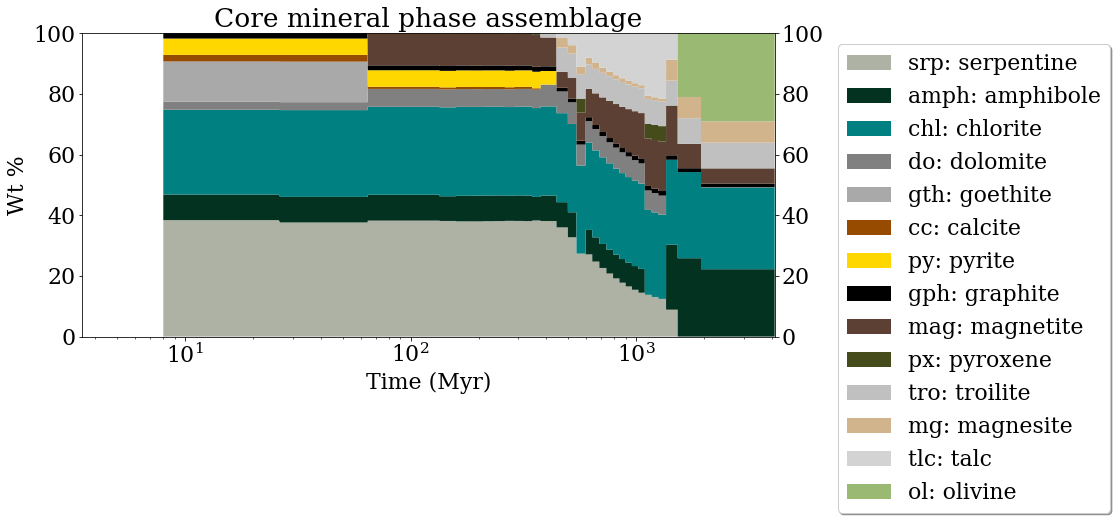

In [38]:
plotPhaseAssemblageTest(Ceres,0, "Core mineral phase assemblage",minorPhases="test")
plt.xscale("log")
plt.savefig('FigS2b.pdf',bbox_inches='tight')